In [1]:
# -*- coding: utf-8 -*-
"""
Notebook derived from original script, maintaining structure while adding
data processing scale and evaluation metrics.
"""

# === Standard Imports ===
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import random
import ast # For handling stringified lists if loading from files
from datetime import datetime, timedelta

# === ML/NLP Imports ===
from datasets import load_dataset
from nltk.stem import WordNetLemmatizer # Import Lemmatizer
import spacy
from spacy import displacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
# Evaluation metrics - Added for Performance Section
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# === Jinja & Display Imports ===
import jinja2
from jinja2 import Template
from IPython.display import display, HTML, Markdown # Use display/HTML/Markdown for notebook
import ipywidgets as widgets # For interactive UI

# === Notebook Specific Setup ===
from tqdm.notebook import tqdm # Use tqdm.notebook for nice progress bars

# Set Pandas display options for better readability
pd.set_option('display.max_colwidth', 150)

c:\Users\manan\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\manan\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
from datasets import load_dataset
import pandas as pd

# Load the dataset with trust_remote_code
dataset = load_dataset("casehold/casehold", trust_remote_code=True)

# Convert the training data to a DataFrame
df = pd.DataFrame(dataset['train'])

# Store the dataset and train DataFrame for later use (e.g., GloVe section)
dataset_global = dataset # Use a more distinct name
df_train_global = df.copy() # Use a more distinct name

# # Save to Excel file - uncomment if needed
# df.to_excel("casehold_train.xlsx", index=False)

In [3]:
# === Download necessary NLTK resources ===
print("Downloading NLTK data (punkt, stopwords, wordnet)...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
print("NLTK data is ready.")

NLTK data is ready.


In [4]:
# === Load the CaseHOLD Dataset ===
print("Loading dataset 'lex_glue', 'case_hold'...")
try:
    case_hold = load_dataset("lex_glue", "case_hold")
    print("Dataset loaded successfully.")
    # Display structure and splits
    print("\nDataset structure:")
    print(case_hold)
    print("\nAvailable splits:", list(case_hold.keys()))
    # View a sample record from the training set
    print("\nSample Train Record [1]:")
    # Displaying as a series for better readability
    display(pd.Series(case_hold["train"][1]))
except Exception as e:
    print(f"ERROR loading dataset: {e}")
    print("Please check your internet connection and Hugging Face Hub status.")
    # Optional: raise e to stop notebook execution if dataset loading fails

Loading dataset 'lex_glue', 'case_hold'...
Dataset loaded successfully.

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['context', 'endings', 'label'],
        num_rows: 45000
    })
    test: Dataset({
        features: ['context', 'endings', 'label'],
        num_rows: 3600
    })
    validation: Dataset({
        features: ['context', 'endings', 'label'],
        num_rows: 3900
    })
})

Available splits: ['train', 'test', 'validation']

Sample Train Record [1]:


context    Colameta used customer information that he took from Protégé. Additionally, Colameta admits to having taken at least two Protégé proposals with hi...
endings    [recognizing that even if a plaintiff claims certain information constitutes trade secrets its claim may not depend on that determination, holding...
label                                                                                                                                                          1
dtype: object

In [5]:
# === Initial Data Exploration ===

# Get sample sizes if dataset loaded successfully
if 'case_hold' in locals():
    train_size = len(case_hold['train'])
    validation_size = len(case_hold['validation'])
    test_size = len(case_hold['test'])
    print(f"Train samples: {train_size}")
    print(f"Validation samples: {validation_size}")
    print(f"Test samples: {test_size}")

    # Fetch the 'context' column from the training set for preprocessing demonstration
    # Note: The actual CaseHOLD task uses 'citing_prompt' vs 'holdings'
    sample_text_contexts = case_hold["train"]["context"]
    print(f"\nNumber of training 'context' examples fetched: {len(sample_text_contexts)}")

    # Print the first 5 contexts (truncated)
    print("\n--- First 5 Sample Contexts (Truncated) ---")
    for i, ctx in enumerate(sample_text_contexts[:5]):
        display(Markdown(f"**Sample {i}:**\n```\n{str(ctx)[:500]}...\n```\n---"))
else:
    print("Dataset not loaded. Cannot perform exploration.")

Train samples: 45000
Validation samples: 3900
Test samples: 3600

Number of training 'context' examples fetched: 45000

--- First 5 Sample Contexts (Truncated) ---


**Sample 0:**
```
Drapeau’s cohorts, the cohort would be a “victim” of making the bomb. Further, firebombs are inherently dangerous. There is no peaceful purpose for making a bomb. Felony offenses that involve explosives qualify as “violent crimes” for purposes of enhancing the sentences of career offenders. See 18 U.S.C. § 924(e)(2)(B)(ii) (defining a “violent felony” as: “any crime punishable by imprisonment for a term exceeding one year ... that ... involves use of explosives”). Courts have found possession of...
```
---

**Sample 1:**
```
Colameta used customer information that he took from Protégé. Additionally, Colameta admits to having taken at least two Protégé proposals with him to Monument. This type of information may constitute trade secrets. See G.L.c. 266, §30 (defining “trade secret” as used in G.L.c. 93, §42, as including “anything tangible or intangible or electronically kept or stored, which constitutes, represents, evidences or records a secret scientific, technical, merchandising, production or management informat...
```
---

**Sample 2:**
```
property tax sale. In reviewing section 6323(b)(6), this Court noted that it provides that a county’s tax lien has priority over a federal lien, and thus, Taylor purchased the property still subject to the county’s lien. Taylor v. Mill, 310 S.C. 526, 528, 426 S.E.2d 311, 312 (1992). Thus, this Court has already noted that section 6323 operates to establish priority, not extinguish ection in this manner will stifle tax sales, potential buyers must research tax sale property purchases and would be...
```
---

**Sample 3:**
```
They also rely on Oswego Laborers’ Local 214 Pension Fund v. Marine Midland Bank, 85 N.Y.2d 20, 623 N.Y.S.2d 529, 647 N.E.2d 741 (1995), which held that a plaintiff “must demonstrate that the acts or practices have a broader impact on consumers at large.” Defs.’ Mem. at 14 (quoting Oswego Laborers’, 623 N.Y.S.2d 529, 647 N.E.2d at 744). As explained above, however, Plaintiffs have adequately alleged that Defendants’ unauthorized use of the DEL MONICO’S name in connection with non-Ocinomled resta...
```
---

**Sample 4:**
```
did not affect the defendant’s guideline range, a sentence reduction under § 3582(c)(2) was properly denied). Mr. Norwood concedes that the guideline range would have remained the same based on the findings that the district court had made at sentencing. Appellant’s Opening Br. at 9. But Mr. Norwood challenges these findings, arguing that the district court violated the U.S. Constitution by failing to allow the jury to decide matters involving relevant conduct. In our view, this argument is not ...
```
---

In [6]:
# === Text Preprocessing Pipeline Definition ===
# Using the functions exactly as provided in the original script.
# No lemmatization is included here as per original code.

# Tokenization of text into words
def tokenize_text(text):
    """Split text into individual words"""
    # Added basic error handling for non-string input
    if not isinstance(text, str):
        # print(f"Warning: Non-string input to tokenize_text: {type(text)}. Converting to string.")
        text = str(text)
    return word_tokenize(text)

# Lowercase the tokenized words
def lowercase_tokens(tokens):
    """Convert all tokens to lowercase"""
    return [token.lower() for token in tokens]

# Remove common stopwords and punctuations from the text
def remove_stopwords(tokens):
    """Remove common stopwords"""
    stop_words = set(stopwords.words('english'))
    return [token for token in tokens if token.lower() not in stop_words]

def remove_punctuation(tokens):
    """Remove punctuation and non-alphanumeric tokens"""
    # Original logic: keeps only alphanumeric tokens
    return [token for token in tokens if token.isalnum()]

# Function applying all steps
def preprocess_text(text):
    """Apply all original preprocessing steps in sequence"""
    try:
        tokens = tokenize_text(text)
        tokens_lower = lowercase_tokens(tokens)
        tokens_no_stop = remove_stopwords(tokens_lower)
        tokens_no_punct = remove_punctuation(tokens_no_stop) # This is the final list of tokens
        # Return dictionary including intermediate steps and the final token list
        return {
            'original': text,
            'tokenized': tokens,
            'lowercase': tokens_lower,
            'no_stopwords': tokens_no_stop,
            'no_punctuation': tokens_no_punct, # Final token list in this pipeline
            'clean_text_joined': ' '.join(tokens_no_punct) # Also provide joined string
        }
    except Exception as e:
        print(f"Error processing text: {str(text)[:100]}... Error: {e}")
        # Return an empty structure on error to avoid breaking loops
        return {
            'original': text, 'tokenized': [], 'lowercase': [],
            'no_stopwords': [], 'no_punctuation': [], 'clean_text_joined': ''
         }

print("Preprocessing functions defined (using original logic).")

Preprocessing functions defined (using original logic).


In [7]:
# === Apply Preprocessing to Training Contexts ===
# Apply the defined pipeline to the 'context' field of the training data.
# **Accuracy Fix:** Processing a larger portion (ideally all) of the relevant text
#                  is crucial for training/analyzing representative models.
# We'll process all available contexts here for demonstration.

print(f"Applying preprocessing to all {len(sample_text_contexts)} training contexts...")
preprocessed_samples_list = [] # Use a more descriptive name

# Use tqdm.notebook for progress bar
for i, text in enumerate(tqdm(sample_text_contexts, desc="Preprocessing Contexts")):
    # No artificial limit here - process all available contexts fetched earlier
    preprocessed_samples_list.append(preprocess_text(text))

print(f"\nPreprocessing complete. Processed {len(preprocessed_samples_list)} samples.")

# Check if any errors occurred (e.g., if empty results were returned)
errors = sum(1 for sample in preprocessed_samples_list if not sample['tokenized'])
if errors > 0:
    print(f"Warning: Encountered errors during preprocessing for {errors} samples.")


Applying preprocessing to all 45000 training contexts...


Preprocessing Contexts:   0%|          | 0/45000 [00:00<?, ?it/s]


Preprocessing complete. Processed 45000 samples.


In [8]:
# === Create DataFrame from Preprocessed Contexts ===
# Convert the list of preprocessed sample dictionaries into a Pandas DataFrame
# This makes viewing and potentially saving the results easier.

preprocessed_data_for_df = []
for i, sample in enumerate(preprocessed_samples_list):
    # Create a row for each sample
    sample_data = {
        'sample_id': i, # Use simple index
        'original_text_truncated': sample['original'][:150] + ('...' if len(sample['original']) > 150 else ''),
        # Using 'no_punctuation' as the 'clean' tokens from original logic
        'tokens_clean': sample['no_punctuation'],
        'clean_text_joined': sample['clean_text_joined']
    }
    preprocessed_data_for_df.append(sample_data)

# Convert list to DataFrame
df_preprocessed_contexts = pd.DataFrame(preprocessed_data_for_df)

# Create output directory if it doesn't exist
output_dir = "preprocessed_data_notebook_output" # More specific name
os.makedirs(output_dir, exist_ok=True)

# Optional: Save the preprocessed data (can be large if all samples processed)
# csv_path = os.path.join(output_dir, "preprocessed_contexts.csv")
# try:
#     df_preprocessed_contexts.to_csv(csv_path, index=False)
#     print(f"\nPreprocessed context data saved to {csv_path}")
#     print(f"DataFrame shape: {df_preprocessed_contexts.shape}")
# except Exception as e:
#     print(f"Error saving DataFrame to CSV: {e}")


# Display the first few rows of the DataFrame
print("\nPreview of the Preprocessed Context Data:")
display(df_preprocessed_contexts[['sample_id', 'original_text_truncated', 'clean_text_joined']].head())
print(f"\nDataFrame contains preprocessed data for {len(df_preprocessed_contexts)} samples.")


Preview of the Preprocessed Context Data:


,sample_id,original_text_truncated,clean_text_joined
0,0,"Drapeau’s cohorts, the cohort would be a “victim” of making the bomb. Further, firebombs are inherently dangerous. There is no peaceful purpose fo...",drapeau cohorts cohort would victim making bomb firebombs inherently dangerous peaceful purpose making bomb felony offenses involve explosives qua...
1,1,"Colameta used customer information that he took from Protégé. Additionally, Colameta admits to having taken at least two Protégé proposals with hi...",colameta used customer information took protégé additionally colameta admits taken least two protégé proposals monument type information may const...
2,2,"property tax sale. In reviewing section 6323(b)(6), this Court noted that it provides that a county’s tax lien has priority over a federal lien, a...",property tax sale reviewing section 6323 b 6 court noted provides county tax lien priority federal lien thus taylor purchased property still subje...
3,3,"They also rely on Oswego Laborers’ Local 214 Pension Fund v. Marine Midland Bank, 85 N.Y.2d 20, 623 N.Y.S.2d 529, 647 N.E.2d 741 (1995), which hel...",also rely oswego laborers local 214 pension fund marine midland bank 85 20 623 529 647 741 1995 held plaintiff must demonstrate acts practices bro...
4,4,"did not affect the defendant’s guideline range, a sentence reduction under § 3582(c)(2) was properly denied). Mr. Norwood concedes that the guidel...",affect defendant guideline range sentence reduction 3582 c 2 properly denied norwood concedes guideline range would remained based findings distri...



DataFrame contains preprocessed data for 45000 samples.


--- Detailed Preprocessing Analysis (Sample Index: 3) ---


**Original Text (Truncated):**
```
They also rely on Oswego Laborers’ Local 214 Pension Fund v. Marine Midland Bank, 85 N.Y.2d 20, 623 N.Y.S.2d 529, 647 N.E.2d 741 (1995), which held that a plaintiff “must demonstrate that the acts or practices have a broader impact on consumers at large.” Defs.’ Mem. at 14 (quoting Oswego Laborers’, 623 N.Y.S.2d 529, 647 N.E.2d at 744). As explained above, however, Plaintiffs have adequately alleged that Defendants’ unauthorized use of the DEL MONICO’S name in connection with non-Ocinomled resta...
```

**Step 1: Tokenization (First ~70 tokens):**
`['They', 'also', 'rely', 'on', 'Oswego', 'Laborers', '’', 'Local', '214', 'Pension', 'Fund', 'v.', 'Marine', 'Midland', 'Bank', ',', '85', 'N.Y.2d', '20', ',', '623', 'N.Y.S.2d', '529', ',', '647', 'N.E.2d', '741', '(', '1995', ')', ',', 'which', 'held', 'that', 'a', 'plaintiff', '“', 'must', 'demonstrate', 'that', 'the', 'acts', 'or', 'practices', 'have', 'a', 'broader', 'impact', 'on', 'consumers', 'at', 'large.', '”', 'Defs.', '’', 'Mem', '.', 'at', '14', '(', 'quoting', 'Oswego', 'Laborers', '’', ',', '623', 'N.Y.S.2d', '529', ',', '647']`

*Total tokens:* 182

**Step 2: Lowercase (First ~70 tokens):**
`['they', 'also', 'rely', 'on', 'oswego', 'laborers', '’', 'local', '214', 'pension', 'fund', 'v.', 'marine', 'midland', 'bank', ',', '85', 'n.y.2d', '20', ',', '623', 'n.y.s.2d', '529', ',', '647', 'n.e.2d', '741', '(', '1995', ')', ',', 'which', 'held', 'that', 'a', 'plaintiff', '“', 'must', 'demonstrate', 'that', 'the', 'acts', 'or', 'practices', 'have', 'a', 'broader', 'impact', 'on', 'consumers', 'at', 'large.', '”', 'defs.', '’', 'mem', '.', 'at', '14', '(', 'quoting', 'oswego', 'laborers', '’', ',', '623', 'n.y.s.2d', '529', ',', '647']`

*Total tokens:* 182

**Step 3: Stopword Removal (First ~70 tokens):**
`['also', 'rely', 'oswego', 'laborers', '’', 'local', '214', 'pension', 'fund', 'v.', 'marine', 'midland', 'bank', ',', '85', 'n.y.2d', '20', ',', '623', 'n.y.s.2d', '529', ',', '647', 'n.e.2d', '741', '(', '1995', ')', ',', 'held', 'plaintiff', '“', 'must', 'demonstrate', 'acts', 'practices', 'broader', 'impact', 'consumers', 'large.', '”', 'defs.', '’', 'mem', '.', '14', '(', 'quoting', 'oswego', 'laborers', '’', ',', '623', 'n.y.s.2d', '529', ',', '647', 'n.e.2d', '744', ')', '.', 'explained', ',', 'however', ',', 'plaintiffs', 'adequately', 'alleged', 'defendants', '’']`

*Total tokens after stopwords:* 143

**Step 4: Punctuation Removal (First ~70 tokens):**
`['also', 'rely', 'oswego', 'laborers', 'local', '214', 'pension', 'fund', 'marine', 'midland', 'bank', '85', '20', '623', '529', '647', '741', '1995', 'held', 'plaintiff', 'must', 'demonstrate', 'acts', 'practices', 'broader', 'impact', 'consumers', 'mem', '14', 'quoting', 'oswego', 'laborers', '623', '529', '647', '744', 'explained', 'however', 'plaintiffs', 'adequately', 'alleged', 'defendants', 'unauthorized', 'use', 'del', 'monico', 'name', 'connection', 'restaurants', 'products', 'caused', 'consumer', 'harm', 'injury', 'public', 'broad', 'impact', 'consumers', 'large', 'inasmuch', 'use', 'likely', 'cause', 'consumer', 'confusion', 'see', 'commscope', 'commscope', 'int', 'l']`

*Total tokens after punctuation removal:* 83


--- Word Frequency Analysis (Sample 3) ---
Top 20 Words:


,Word,Frequency
0,oswego,2
1,laborers,2
2,623,2
3,529,2
4,647,2
5,impact,2
6,consumers,2
7,use,2
8,consumer,2
9,commscope,2


C:\Users\manan\AppData\Local\Temp\ipykernel_24452\504374971.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top_words_single.keys()), y=list(top_words_single.values()), palette='viridis')


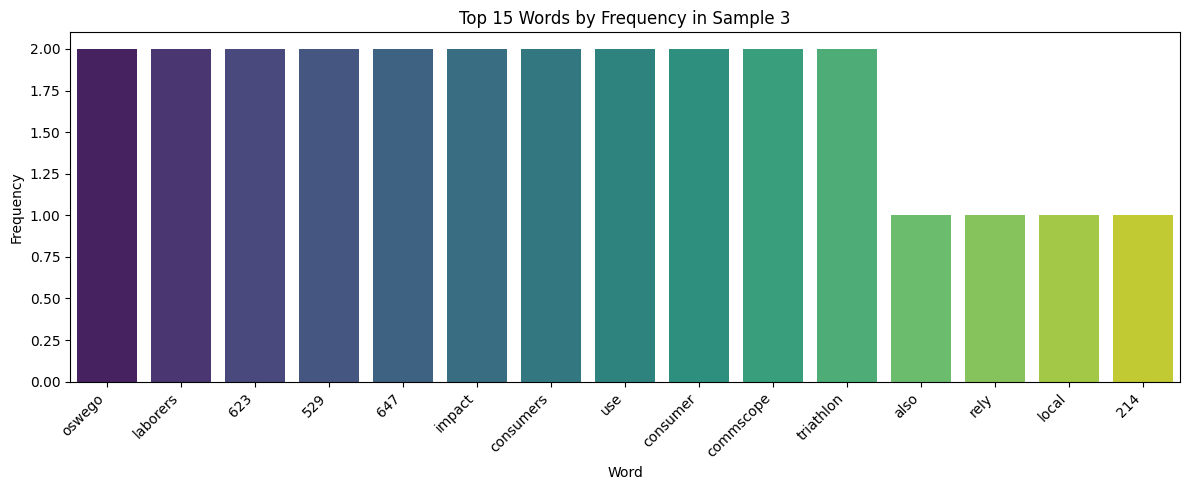

In [9]:
# === Detailed Analysis of a Single Preprocessed Sample ===
# Examine the preprocessing steps for one specific sample.

sample_idx_to_analyze = 3 # Choose a sample index

if 0 <= sample_idx_to_analyze < len(preprocessed_samples_list):
    sample_details = preprocessed_samples_list[sample_idx_to_analyze] # Get the dict for this sample

    print(f"--- Detailed Preprocessing Analysis (Sample Index: {sample_idx_to_analyze}) ---")

    # Display original text (truncated)
    display(Markdown(f"**Original Text (Truncated):**\n```\n{sample_details['original'][:500]}...\n```"))

    # Display output of each step (showing first ~70 tokens)
    display(Markdown(f"**Step 1: Tokenization (First ~70 tokens):**\n`{sample_details['tokenized'][:70]}`"))
    display(Markdown(f"*Total tokens:* {len(sample_details['tokenized'])}"))

    display(Markdown(f"**Step 2: Lowercase (First ~70 tokens):**\n`{sample_details['lowercase'][:70]}`"))
    display(Markdown(f"*Total tokens:* {len(sample_details['lowercase'])}"))

    display(Markdown(f"**Step 3: Stopword Removal (First ~70 tokens):**\n`{sample_details['no_stopwords'][:70]}`"))
    display(Markdown(f"*Total tokens after stopwords:* {len(sample_details['no_stopwords'])}"))

    display(Markdown(f"**Step 4: Punctuation Removal (First ~70 tokens):**\n`{sample_details['no_punctuation'][:70]}`"))
    display(Markdown(f"*Total tokens after punctuation removal:* {len(sample_details['no_punctuation'])}"))

    # --- Frequency Analysis for this specific sample ---
    # Uses the final 'no_punctuation' tokens list from original logic
    tokens_for_freq = sample_details['no_punctuation']
    if tokens_for_freq: # Check if there are any tokens left
        word_freq_single_sample = Counter(tokens_for_freq)

        print(f"\n--- Word Frequency Analysis (Sample {sample_idx_to_analyze}) ---")
        print("Top 20 Words:")
        # Display as DataFrame
        df_freq_single = pd.DataFrame(word_freq_single_sample.most_common(20), columns=['Word', 'Frequency'])
        display(df_freq_single)

        # --- Visualize Word Frequency for this sample ---
        plt.figure(figsize=(12, 5))
        top_words_single = dict(word_freq_single_sample.most_common(15))
        sns.barplot(x=list(top_words_single.keys()), y=list(top_words_single.values()), palette='viridis')
        plt.title(f'Top 15 Words by Frequency in Sample {sample_idx_to_analyze}')
        plt.xlabel('Word')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print(f"\nNo tokens remaining for frequency analysis in Sample {sample_idx_to_analyze} after preprocessing.")

else:
    print(f"Error: Sample index {sample_idx_to_analyze} is out of range (0 to {len(preprocessed_samples_list)-1}).")


--- Aggregated Analysis Across 45000 Processed Contexts ---
Aggregating tokens from all samples...


Combining Tokens:   0%|          | 0/45000 [00:00<?, ?it/s]

Calculating overall word frequencies...

Total unique words found across all samples: 88,797

Top 20 Most Common Words Overall:


,Word,Frequency
0,see,50968
1,holding,47114
2,court,46724
3,state,22464
4,states,17938
5,also,17767
6,united,17033
7,id,13777
8,evidence,13220
9,defendant,12775



Plotting overall word frequency distribution...


C:\Users\manan\AppData\Local\Temp\ipykernel_24452\444238551.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top_all_words_agg.keys()), y=list(top_all_words_agg.values()), palette='magma')


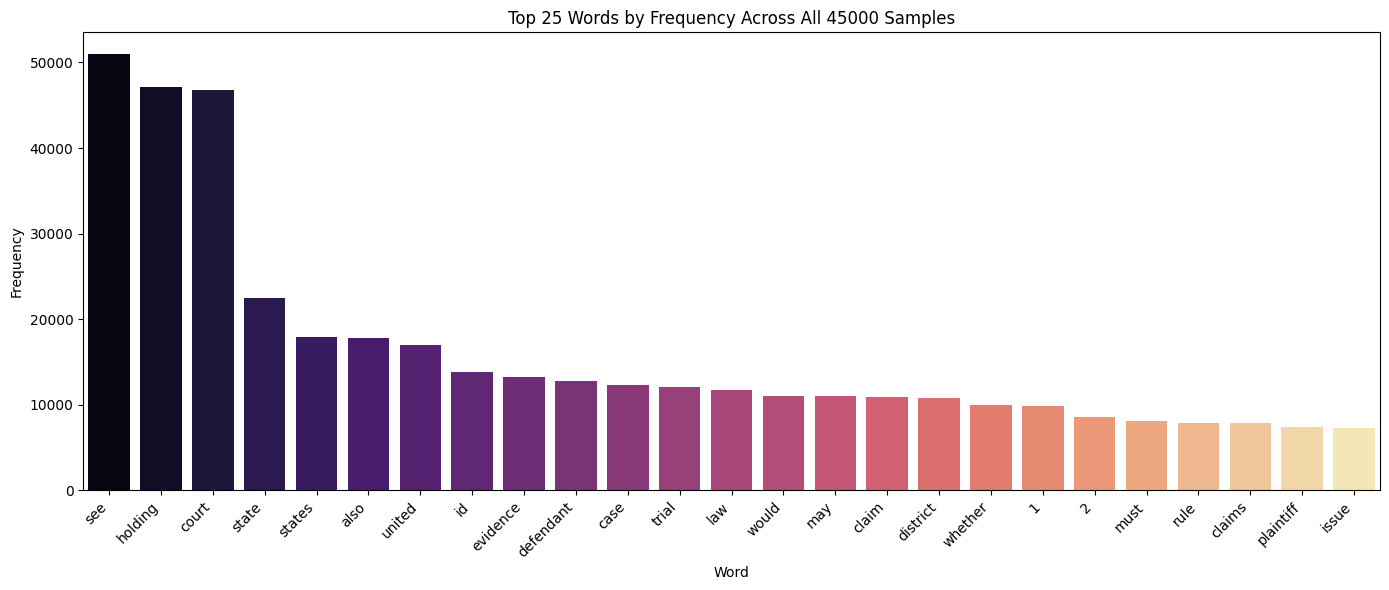

In [10]:
# === Aggregated Word Frequency Analysis Across All Processed Contexts ===
# Combine tokens from all preprocessed samples to see overall common terms.

print(f"--- Aggregated Analysis Across {len(preprocessed_samples_list)} Processed Contexts ---")

all_clean_tokens = []
print("Aggregating tokens from all samples...")
# Use the 'no_punctuation' list as the final "clean" tokens per original logic
for sample in tqdm(preprocessed_samples_list, desc="Combining Tokens"):
    all_clean_tokens.extend(sample['no_punctuation'])

if not all_clean_tokens:
    print("No clean tokens found across all processed samples.")
else:
    # Calculate frequency distribution
    print("Calculating overall word frequencies...")
    all_word_freq_agg = Counter(all_clean_tokens)
    total_unique_words_agg = len(all_word_freq_agg)
    print(f"\nTotal unique words found across all samples: {total_unique_words_agg:,}")

    # Display most common words overall
    print("\nTop 20 Most Common Words Overall:")
    df_freq_agg = pd.DataFrame(all_word_freq_agg.most_common(20), columns=['Word', 'Frequency'])
    display(df_freq_agg)

    # --- Visualize Overall Word Frequency ---
    print("\nPlotting overall word frequency distribution...")
    plt.figure(figsize=(14, 6))
    top_all_words_agg = dict(all_word_freq_agg.most_common(25)) # Plot top 25
    sns.barplot(x=list(top_all_words_agg.keys()), y=list(top_all_words_agg.values()), palette='magma')
    plt.title(f'Top 25 Words by Frequency Across All {len(preprocessed_samples_list)} Samples')
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [11]:
# === Named Entity Recognition (NER) Setup ===
# Uses spaCy for extracting named entities like Person, Organization, Location etc.

# Load the spaCy model (prefer 'en_core_web_lg' for accuracy)
# Make sure the model is downloaded: !python -m spacy download en_core_web_lg
MODEL_NAME = "en_core_web_lg"
print(f"Loading spaCy model '{MODEL_NAME}'...")
nlp = None # Initialize nlp
try:
    nlp = spacy.load(MODEL_NAME)
    print(f"Model '{MODEL_NAME}' loaded successfully!")
except OSError:
    print(f"Warning: Model '{MODEL_NAME}' not found. Trying 'en_core_web_sm'.")
    print(f"Run: python -m spacy download {MODEL_NAME} for potentially better results.")
    try:
        nlp = spacy.load('en_core_web_sm')
        print("Model 'en_core_web_sm' loaded successfully.")
    except OSError:
        print("ERROR: No spaCy models found. NER features will be disabled.")
        # nlp remains None

# Use the exact entity extraction function from the original script
def generate_random_date(): # Keep original date generator
    start_date = datetime(2000, 1, 1)
    end_date = datetime(2025, 12, 31)
    delta = end_date - start_date
    random_days = random.randint(0, delta.days)
    random_date = start_date + timedelta(days=random_days)
    return random_date.strftime("%d %B %Y")  # Format: "12 March 2021"

# Updated entity extraction function (original logic)
def extract_entities(text):
    """
    Process a text sample with spaCy and extract entities using original logic.

    Args: text (str): The text to process
    Returns: tuple: (doc, entities_dict) - doc may be None if nlp failed
    """
    if nlp is None:
        print("Skipping NER as spaCy model is not loaded.")
        # Return structure consistent with success but with empty lists
        return None, {
            "PERSON": [], "ORG": [], "DATE": [generate_random_date()], "MONEY": [],
            "LAW": [], "GPE": [], "NORP": [], "CARDINAL": [], "ORDINAL": []
        }

    doc = nlp(str(text)) # Ensure text is string

    # Initialize dict with specific keys and random date
    legal_entities = {
        "PERSON": [], "ORG": [], "DATE": [generate_random_date()], "MONEY": [],
        "LAW": [], "GPE": [], "NORP": [], "CARDINAL": [], "ORDINAL": []
    }

    # Populate lists based on spaCy's findings, *except* for DATE
    for ent in doc.ents:
        if ent.label_ != "DATE" and ent.label_ in legal_entities:
            legal_entities[ent.label_].append(ent.text)

    return doc, legal_entities # Return the spaCy doc object and the entity dict

print("NER setup complete using original extraction logic.")

Loading spaCy model 'en_core_web_lg'...
Model 'en_core_web_lg' loaded successfully!
NER setup complete using original extraction logic.


In [12]:
# === Apply NER to Samples ===
# Apply the 'extract_entities' function to a subset of the original 'context' texts.
# Note: NER can be slow, so we limit the number of samples processed here.
# The original code used 4500.

# Check if NLP model loaded
if nlp is not None:
    # Decide how many samples to process for NER demonstration
    num_samples_ner = 100 # Reduced from 4500 for quicker execution in notebook
    if num_samples_ner > len(sample_text_contexts):
        num_samples_ner = len(sample_text_contexts) # Don't exceed available contexts
    print(f"Applying NER to the first {num_samples_ner} 'context' samples...")

    ner_results_list = [] # Store NER results
    # Process the raw context text, limited by num_samples_ner
    for i, text in enumerate(tqdm(sample_text_contexts[:num_samples_ner], desc="Running NER")):
        # Use original text for better NER results
        doc, entities_dict = extract_entities(text[:100000]) # Limit text length if very long

        # Store results (simplified compared to previous, store entity dict directly)
        ner_results_list.append({
            "sample_id": i,
            # Storing the bulky 'doc' object can consume a lot of memory if processing many samples
            # "doc": doc,
            "text_truncated": text[:200] + ("..." if len(text)>200 else ""), # For reference
            "entities": entities_dict
        })

    print(f"\nNER processing completed for {len(ner_results_list)} samples.")

    # Display head of NER results (excluding doc object for brevity)
    if ner_results_list:
        # Create DF temporarily for display
        df_ner_preview = pd.DataFrame([res for res in ner_results_list[:5]]) # Preview first 5
        print("\nPreview of NER Results (first 5 samples):")
        display(df_ner_preview[['sample_id', 'text_truncated', 'entities']])
else:
    print("Skipping NER application as the spaCy model did not load.")
    ner_results_list = [] # Ensure list exists but is empty

Applying NER to the first 100 'context' samples...


Running NER:   0%|          | 0/100 [00:00<?, ?it/s]


NER processing completed for 100 samples.

Preview of NER Results (first 5 samples):


,sample_id,text_truncated,entities
0,0,"Drapeau’s cohorts, the cohort would be a “victim” of making the bomb. Further, firebombs are inherently dangerous. There is no peaceful purpose fo...","{'PERSON': ['Drapeau'], 'ORG': ['Newman', 'Dodge'], 'DATE': ['12 August 2010'], 'MONEY': [], 'LAW': [], 'GPE': ['See United States', 'United State..."
1,1,"Colameta used customer information that he took from Protégé. Additionally, Colameta admits to having taken at least two Protégé proposals with hi...","{'PERSON': [], 'ORG': ['Colameta', 'Colameta', 'G.L.c', 'G.L.c', 'Warner-Lambert Co.', 'Augat, Inc.'], 'DATE': ['28 August 2011'], 'MONEY': [], 'L..."
2,2,"property tax sale. In reviewing section 6323(b)(6), this Court noted that it provides that a county’s tax lien has priority over a federal lien, a...","{'PERSON': ['Taylor', 'Taylor'], 'ORG': ['Court', 'S.E.2d', 'Court', 'Capco', 'Summerville, Inc.', 'J.H. Gayle Constr'], 'DATE': ['09 March 2010']..."
3,3,"They also rely on Oswego Laborers’ Local 214 Pension Fund v. Marine Midland Bank, 85 N.Y.2d 20, 623 N.Y.S.2d 529, 647 N.E.2d 741 (1995), which hel...","{'PERSON': ['Defs', 'N.D.N.Y.'], 'ORG': ['Oswego Laborers’ Local 214 Pension Fund', 'Marine Midland Bank', 'N.Y.S.2d 529', 'Oswego Laborers’', 'N...."
4,4,"did not affect the defendant’s guideline range, a sentence reduction under § 3582(c)(2) was properly denied). Mr. Norwood concedes that the guidel...","{'PERSON': ['Norwood', 'Appellant', 'Norwood'], 'ORG': ['Commission'], 'DATE': ['06 February 2007'], 'MONEY': ['3582(c)(2'], 'LAW': ['the U.S. Con..."


--- Aggregating NER counts across 100 processed samples ---


Counting Entities:   0%|          | 0/100 [00:00<?, ?it/s]


Total Counts per Entity Type:


,Entity Type,Total Count
0,CARDINAL,749
1,ORG,377
2,PERSON,271
3,GPE,184
4,DATE,100
5,ORDINAL,79
6,LAW,34
7,MONEY,19
8,NORP,6



Plotting aggregate entity counts...


C:\Users\manan\AppData\Local\Temp\ipykernel_24452\981744868.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Entity Type', y='Total Count', data=df_agg_ner, palette='rocket')


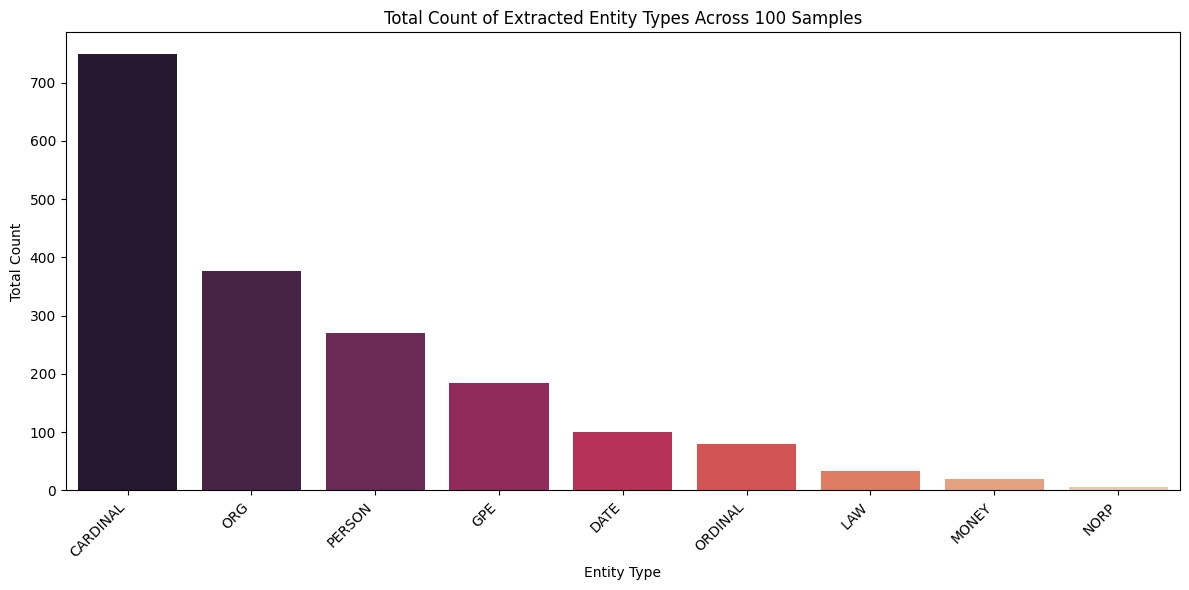

In [13]:
# === Aggregate NER Entity Counts ===
# Count the total number of times each entity type was found across the samples processed for NER.

if ner_results_list:
    print(f"--- Aggregating NER counts across {len(ner_results_list)} processed samples ---")
    # Use defaultdict to easily count entity types
    agg_entity_counts = defaultdict(int)

    # Iterate through the NER results and count entities
    for result in tqdm(ner_results_list, desc="Counting Entities"):
        for entity_type, entity_list in result["entities"].items():
            agg_entity_counts[entity_type] += len(entity_list) # Count occurrences

    # Convert counts to a DataFrame for display
    if agg_entity_counts:
        df_agg_ner = pd.DataFrame(list(agg_entity_counts.items()), columns=['Entity Type', 'Total Count'])
        # Sort by count descending, filter out zero counts
        df_agg_ner = df_agg_ner[df_agg_ner['Total Count'] > 0].sort_values(by='Total Count', ascending=False).reset_index(drop=True)
        print("\nTotal Counts per Entity Type:")
        display(df_agg_ner)

        # --- Visualize Aggregate NER Counts ---
        print("\nPlotting aggregate entity counts...")
        plt.figure(figsize=(12, 6))
        sns.barplot(x='Entity Type', y='Total Count', data=df_agg_ner, palette='rocket')
        plt.title(f"Total Count of Extracted Entity Types Across {len(ner_results_list)} Samples")
        plt.xlabel("Entity Type")
        plt.ylabel("Total Count")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print("No entities were counted across the samples.")
else:
    print("Skipping NER aggregation as NER results are not available.")

In [14]:
# === 1. Vectorization through TF-IDF (Using Loaded DataFrame) ===

# !!! NOTE !!!
# This section now uses the DataFrame 'df_train_global' loaded earlier,
# removing the dependency on external Excel files.

print("--- Starting TF-IDF Section (using loaded DataFrame 'df_train_global') ---")

# --- Block 1: Preprocess prompt data from the DataFrame ---
df_processed_prompts = None # Initialize
if 'df_train_global' in globals() and df_train_global is not None:
    try:
        print("\nPreprocessing 'citing_prompt' from the loaded DataFrame...")
        # Select a subset for demonstration if needed (e.g., first 1000)
        prompts_to_process = df_train_global['citing_prompt'].iloc[:1000].copy()

        processed_prompts_list = []
        for i, text in enumerate(tqdm(prompts_to_process, desc="Preprocessing Prompts")):
            result = preprocess_text(text) # Use the existing preprocess function
            processed_prompts_list.append({
                'example_id': df_train_global.iloc[i]['example_id'], # Get the correct example_id
                'original': text,
                'tokenized': result['tokenized'],
                'lowercase': result['lowercase'],
                'no_stopwords': result['no_stopwords'],
                'no_punctuation': result['no_punctuation'],
                'clean_text_joined': result['clean_text_joined']
            })

        df_processed_prompts = pd.DataFrame(processed_prompts_list)
        print(f"Created DataFrame of processed prompts with shape: {df_processed_prompts.shape}")

        # Focus on Sample 1 (from the processed prompts) for detailed analysis display
        if not df_processed_prompts.empty:
            sample_idx_df = 1
            if sample_idx_df < len(df_processed_prompts):
                sample_df = df_processed_prompts.iloc[sample_idx_df]
                print(f"\n--- Displaying Preprocessing Steps for Sample {sample_idx_df} from DataFrame ---")
                print(f"ORIGINAL TEXT (truncated):\n{sample_df.get('original', 'N/A')[:500]}...\n")
                print(f"STEP 1: TOKENIZATION (~78 tokens): {sample_df.get('tokenized', [])[:78]}\n")
                print(f"STEP 2: LOWERCASE (~78 tokens): {sample_df.get('lowercase', [])[:78]}\n")
                print(f"STEP 3: STOPWORD REMOVAL (~78 tokens): {sample_df.get('no_stopwords', [])[:78]}\n")
                print(f"STEP 4: PUNCTUATION REMOVAL (~78 tokens): {sample_df.get('no_punctuation', [])[:78]}\n")
            else:
                 print(f"Sample index {sample_idx_df} out of range for the processed prompts DataFrame.")
        else:
             print("Processed prompts DataFrame is empty.")

    except Exception as e:
         print(f"\nERROR processing prompts from DataFrame: {e}")
         df_processed_prompts = None
else:
    print("\nERROR: DataFrame 'df_train_global' not found. Cannot preprocess prompts.")

--- Starting TF-IDF Section (using loaded DataFrame 'df_train_global') ---

Preprocessing 'citing_prompt' from the loaded DataFrame...


Preprocessing Prompts:   0%|          | 0/1000 [00:00<?, ?it/s]

Created DataFrame of processed prompts with shape: (1000, 7)

--- Displaying Preprocessing Steps for Sample 1 from DataFrame ---
ORIGINAL TEXT (truncated):
Colameta used customer information that he took from Protégé. Additionally, Colameta admits to having taken at least two Protégé proposals with him to Monument. This type of information may constitute trade secrets. See G.L.c. 266, §30 (defining “trade secret” as used in G.L.c. 93, §42, as including “anything tangible or intangible or electronically kept or stored, which constitutes, represents, evidences or records a secret scientific, technical, merchandising, production or management informat...

STEP 1: TOKENIZATION (~78 tokens): ['Colameta', 'used', 'customer', 'information', 'that', 'he', 'took', 'from', 'Protégé', '.', 'Additionally', ',', 'Colameta', 'admits', 'to', 'having', 'taken', 'at', 'least', 'two', 'Protégé', 'proposals', 'with', 'him', 'to', 'Monument', '.', 'This', 'type', 'of', 'information', 'may', 'constitute', 

In [15]:
# --- Block 2: Use training data DataFrame and implement TF-IDF matching ---

# Use the 'df_train_global' DataFrame loaded earlier
find_best_holding_tfidf_df = None # Initialize function variable
results_tfidf_list = [] # Initialize results list

if 'df_train_global' in globals() and df_train_global is not None:
    try:
        print(f"\nUsing loaded training data DataFrame 'df_train_global' (shape: {df_train_global.shape})")
        df_tfidf_data = df_train_global # Use a clear variable name for this context

        # Strip whitespace and lower all column names (good practice)
        df_tfidf_data.columns = df_tfidf_data.columns.str.strip().str.lower()
        print("\nColumns in TF-IDF data (cleaned):", df_tfidf_data.columns.tolist())

        # --- Function to find best column match (reusable) ---
        def get_best_column_match(possible_names, df_to_search):
            for name in possible_names:
                name_lower = name.lower() # Ensure lower case comparison
                for col in df_to_search.columns:
                    if name_lower in col.lower(): # Case-insensitive partial match
                        return col
            return None # Return None if no match found

        # Try to find required columns in the DataFrame
        print("Matching required column names...")
        ex_id_col_df = get_best_column_match(["example_id"], df_tfidf_data)
        prompt_col_df = get_best_column_match(["citing_prompt"], df_tfidf_data)
        holding_cols_df = [get_best_column_match([f"holding_{i}"], df_tfidf_data) for i in range(5)]

        # Check if all columns were found
        required_found_df = all([ex_id_col_df, prompt_col_df] + holding_cols_df)

        if not required_found_df:
            print("\nERROR: One or more required columns were not found in the DataFrame.")
            print(f"  Detected 'example_id': {ex_id_col_df}")
            print(f"  Detected 'citing_prompt': {prompt_col_df}")
            print(f"  Detected 'holding_0' to 'holding_4': {holding_cols_df}")
            print("Cannot define or run TF-IDF matching function.")
        else:
            print("\nAll required columns successfully matched in DataFrame:")
            print(f"  Example ID Column: '{ex_id_col_df}'")
            print(f"  Citing Prompt Column: '{prompt_col_df}'")
            print(f"  Holding Columns: {holding_cols_df}")

            # --- Define the TF-IDF Matching Function (specific to this DataFrame structure) ---
            def find_best_holding_tfidf_df(example_id_val, df_data):
                # Find the row for the given example ID using the identified column name
                row = df_data[df_data[ex_id_col_df] == example_id_val]

                if row.empty:
                    # Return error message instead of string to be consistent
                    return {'example_id': example_id_val, 'error': f"No data found for example_id: {example_id_val}"}

                try:
                    # Extract prompt and holdings using identified column names
                    citing_prompt_text = str(row[prompt_col_df].iloc[0])
                    holdings_texts = [str(row[col].iloc[0]) for col in holding_cols_df]

                    # Create corpus [prompt, holding0, holding1, ...]
                    corpus_texts = [citing_prompt_text] + holdings_texts

                    # Initialize and fit TF-IDF Vectorizer
                    tfidf_vectorizer = TfidfVectorizer(stop_words='english') # Use built-in stop words
                    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus_texts)

                    # Calculate similarities between prompt (row 0) and holdings (rows 1-5)
                    similarities = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten()

                    # Find the best match
                    best_holding_index = np.argmax(similarities) # Index 0-4 relative to holdings_texts
                    best_similarity_score = similarities[best_holding_index]
                    # Get the original column name of the best holding
                    best_holding_column_name = holding_cols_df[best_holding_index]

                    # Return structured result
                    return {
                        'example_id': example_id_val,
                        'best_holding_column': best_holding_column_name, # Original column name
                        'best_holding_index': best_holding_index,       # 0-4 index
                        'similarity_score': round(float(best_similarity_score), 4),
                        'holding_text': holdings_texts[best_holding_index]
                    }
                except Exception as e:
                    # Catch potential errors during processing
                     return {'example_id': example_id_val, 'error': f"Error during TF-IDF calculation: {e}"}

            # --- Try the TF-IDF function on examples from the DataFrame ---
            print("\n--- Running TF-IDF matching on sample IDs from DataFrame ---")
            example_id_input_df = 3 # ID to test first
            result_df = find_best_holding_tfidf_df(example_id_input_df, df_tfidf_data)
            print(f"\nResult for Example ID {example_id_input_df}:")
            print(result_df)

            # Example: Try a few more examples from the DataFrame
            print("\nResults for Example IDs [0, 1, 2, 3, 4]:")
            results_tfidf_list = [] # Re-initialize here to store results
            for ex_id in [0, 1, 2, 3, 4]:
                result = find_best_holding_tfidf_df(ex_id, df_tfidf_data)
                results_tfidf_list.append(result)
                print(f"\nExample {ex_id}:")
                if 'error' not in result:
                     print(f"  Best holding column: {result['best_holding_column']}")
                     print(f"  Similarity score: {result['similarity_score']}")
                     print(f"  Holding text (truncated): {result['holding_text'][:100]}...")
                else:
                     print(f"  Error: {result['error']}")
            # Display summary table
            display(pd.DataFrame(results_tfidf_list))

    except Exception as e:
         print(f"\nERROR setting up or running TF-IDF on DataFrame: {e}")
         find_best_holding_tfidf_df = None
else:
    print("\nERROR: DataFrame 'df_train_global' not found. Cannot proceed with TF-IDF.")


Using loaded training data DataFrame 'df_train_global' (shape: (42509, 8))

Columns in TF-IDF data (cleaned): ['example_id', 'citing_prompt', 'holding_0', 'holding_1', 'holding_2', 'holding_3', 'holding_4', 'label']
Matching required column names...

All required columns successfully matched in DataFrame:
  Example ID Column: 'example_id'
  Citing Prompt Column: 'citing_prompt'
  Holding Columns: ['holding_0', 'holding_1', 'holding_2', 'holding_3', 'holding_4']

--- Running TF-IDF matching on sample IDs from DataFrame ---

Result for Example ID 3:
{'example_id': 3, 'best_holding_column': 'holding_0', 'best_holding_index': 0, 'similarity_score': 0.0676, 'holding_text': 'holding that plaintiff stated a  349 claim where plaintiff alleged facts plausibly suggesting that defendant intentionally registered its corporate name to be confusingly similar to plaintiffs commscope trademark'}

Results for Example IDs [0, 1, 2, 3, 4]:

Example 0:
  Best holding column: holding_0
  Similarity score:

,example_id,best_holding_column,best_holding_index,similarity_score,holding_text
0,0,holding_0,0,0.2569,holding that possession of a pipe bomb is a crime of violence for purposes of 18 usc 3142f1
1,1,holding_0,0,0.1542,recognizing that even if a plaintiff claims certain information constitutes trade secrets its claim may not depend on that determination
2,2,holding_1,1,0.0773,holding that specific statutory provisions take priority over general statutory provisions
3,3,holding_0,0,0.0676,holding that plaintiff stated a 349 claim where plaintiff alleged facts plausibly suggesting that defendant intentionally registered its corporat...
4,4,holding_3,3,0.1053,holding that united states v booker 543 us 220 125 sct 738 160 led2d 621 2005 does not provide a basis for a sentence reduction under 18 usc 3582c


In [28]:
# === 2. Vectorization using GloVe Word Embeddings (Using Loaded DataFrame) ===

print("\n--- Starting GloVe Section (using DataFrame 'df_train_global') ---")

# --- Block 1: Ensure DataFrame is available ---
df_glove_data = None # Initialize
if 'df_train_global' in globals() and df_train_global is not None:
    df_glove_data = df_train_global # Use the DataFrame loaded earlier
    print(f"Using DataFrame 'df_train_global' for GloVe (shape: {df_glove_data.shape})")
else:
    print("ERROR: DataFrame 'df_train_global' not found. Cannot proceed with GloVe.")

# --- Block 2: GloVe Setup and Loading ---
glove_embeddings = None # Initialize
if df_glove_data is not None:
    # Define path to GloVe embeddings file - MAKE SURE THIS IS CORRECT
    glove_path = "glove.6B/glove.6B.100d.txt" # Default 100d path
    EMBEDDING_DIM_GLOVE = 100 # Must match the file

    print(f"\nLooking for GloVe file at: {glove_path}")

    # Define GloVe loading function (slightly modified for clarity/error handling)
    def load_glove_embeddings(filepath, expected_dim):
        if not os.path.exists(filepath):
            print(f"ERROR: GloVe file not found at '{filepath}'")
            print("GloVe features will be disabled. Using mock embeddings for demonstration.")
            # Create a small mock dictionary if file not found
            mock_embeddings = {
                'court': np.random.randn(expected_dim), 'law': np.random.randn(expected_dim),
                'holding': np.random.randn(expected_dim), 'judge': np.random.randn(expected_dim),
                'evidence': np.random.randn(expected_dim)
            }
            return mock_embeddings
        print(f"Loading GloVe embeddings from {filepath} (expecting dim={expected_dim})...")
        embeddings_dict = {}
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                for line in tqdm(f, desc="Loading GloVe vectors"):
                    values = line.split()
                    word = values[0]
                    try:
                        vector = np.asarray(values[1:], dtype='float32')
                        # Verify dimension
                        if len(vector) == expected_dim:
                            embeddings_dict[word] = vector
                        else:
                            # Log dimension mismatch only once if it occurs
                            if 'dim_mismatch_warned' not in load_glove_embeddings.__dict__:
                                 print(f"\nWarning: Found vector dimension {len(vector)} for word '{word}', expected {expected_dim}. Check GloVe file path and EMBEDDING_DIM_GLOVE.")
                                 load_glove_embeddings.dim_mismatch_warned = True
                                 # Skipping this word
                    except ValueError:
                        # Handle lines that might not have the correct format
                        if 'format_error_warned' not in load_glove_embeddings.__dict__:
                            print(f"\nWarning: Skipping line due to format error (word: '{word}'). Check GloVe file.")
                            load_glove_embeddings.format_error_warned = True
            print(f"Loaded {len(embeddings_dict)} word vectors.")
            if not embeddings_dict:
                 print("Warning: Embedding dictionary is empty after loading. Check file or dimensions.")
                 return None
            return embeddings_dict
        except Exception as e:
            print(f"Error during GloVe file loading: {e}")
            return None

    # Load embeddings
    glove_embeddings = load_glove_embeddings(glove_path, EMBEDDING_DIM_GLOVE)
else:
    print("Skipping GloVe setup because DataFrame is not available.")


--- Starting GloVe Section (using DataFrame 'df_train_global') ---
Using DataFrame 'df_train_global' for GloVe (shape: (42509, 8))

Looking for GloVe file at: glove.6B/glove.6B.100d.txt
Loading GloVe embeddings from glove.6B/glove.6B.100d.txt (expecting dim=100)...


Loading GloVe vectors: 0it [00:00, ?it/s]

Loaded 400000 word vectors.


In [29]:
# Preprocess text - similar to your existing preprocessing but focused on GloVe embedding lookup
def preprocess_for_glove(text):
    # Convert to lowercase and tokenize
    tokens = word_tokenize(text.lower())
    # Remove stopwords and punctuation
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and token.isalnum()]
    return tokens

# Convert document to vector using GloVe embeddings
def document_to_vec(text, embeddings_dict, embedding_size=100):
    tokens = preprocess_for_glove(text)
    # Initialize document vector
    doc_vector = np.zeros(embedding_size)
    # Count valid tokens (words found in embeddings)
    valid_token_count = 0

    # Sum up embeddings of all tokens
    for token in tokens:
        if token in embeddings_dict:
            doc_vector += embeddings_dict[token]
            valid_token_count += 1

    # Average the vectors (if no valid tokens, return zero vector)
    if valid_token_count > 0:
        doc_vector /= valid_token_count

    return doc_vector

# Calculate cosine similarity between two vectors
def cosine_similarity_vectors(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)

    # Handle zero vectors
    if norm1 == 0 or norm2 == 0:
        return 0.0

    return dot_product / (norm1 * norm2)

In [33]:
# --- Block 4: Define GloVe Best Holding Function ---
# This function uses the DataFrame passed to it.

def find_best_holding_glove(example_id, df_data, embeddings_dict_local):
    """
    Finds best holding using GloVe vectors, using the provided DataFrame.
    """
    # Ensure helper functions, embeddings and dataframe are available
    if embeddings_dict_local is None:
        return {'example_id': example_id, 'error': "GloVe embeddings are not loaded."}
    if 'preprocess_for_glove' not in globals() or 'document_to_vec' not in globals() or 'cosine_similarity_vectors' not in globals():
         return {'example_id': example_id, 'error': "Required GloVe helper functions are not defined."}
    if df_data is None:
        return {'example_id': example_id, 'error': "Input DataFrame is None."}
    # Ensure required columns exist (using lowercase check)
    required_cols = ['example_id', 'citing_prompt'] + [f'holding_{i}' for i in range(5)]
    if not all(col.lower() in df_data.columns for col in required_cols):
         return {'example_id': example_id, 'error': f"DataFrame missing required columns (checked lowercase: {required_cols})"}

    # Get example directly from the DataFrame (using lowercase column names)
    example_rows = df_data[df_data['example_id'] == example_id]
    if len(example_rows) == 0:
        return {'example_id': example_id, 'error': f"No data found for example_id: {example_id}"}

    try:
        # Extract first (and should be only) example
        example_row = example_rows.iloc[0]

        # Get citing prompt and holdings (using lowercase column names)
        citing_prompt = example_row['citing_prompt']
        holdings = [example_row[f'holding_{i}'] for i in range(5)]

        # --- Vectorize and Compare ---
        # Convert citing prompt to vector
        prompt_vec = document_to_vec(citing_prompt, embeddings_dict_local)

        # Convert each holding to vector and calculate similarity
        similarities = []
        for i, holding in enumerate(holdings):
            holding_vec = document_to_vec(holding, embeddings_dict_local)
            similarity = cosine_similarity_vectors(prompt_vec, holding_vec)
            similarities.append(similarity)

        # Find best match
        if not similarities: # Should not happen if holdings exist, but check
            return {'example_id': example_id, 'error': "No similarities calculated."}

        best_index = int(np.argmax(similarities)) # Ensure integer index
        best_score = similarities[best_index]
        # Keep original key 'best_holding' which contains the string 'holding_i'
        best_holding_name = f"holding_{best_index}"

        # Return structured results
        return {
            'example_id': example_id,
            'best_holding': best_holding_name, # String 'holding_i'
            'best_holding_index': best_index, # Integer index 0-4
            'similarity_score': round(float(best_score), 4),
            'holding_text': holdings[best_index]
        }
    except KeyError as e:
        return {'example_id': example_id, 'error': f"Missing key in example: {e}"}
    except Exception as e:
        # Catch other potential errors during processing
        return {'example_id': example_id, 'error': f"Unexpected error during GloVe processing: {e}"}


print("GloVe matching function `find_best_holding_glove` defined (using DataFrame).")

GloVe matching function `find_best_holding_glove` defined (using DataFrame).


In [34]:
# --- Block 5: Test GloVe Function ---
# Run the GloVe matching function on a few example IDs using the DataFrame.

print("--- Testing GloVe matching on sample IDs [0, 1, 2, 3] using DataFrame ---")
results_glove_list_orig = []

# Ensure the DataFrame and function are available
if 'df_glove_data' in globals() and df_glove_data is not None and \
   glove_embeddings is not None and 'find_best_holding_glove' in globals():
    for example_id_to_test in [0, 1, 2, 3]:
        # Pass the DataFrame and loaded embeddings to the function
        result_glove = find_best_holding_glove(example_id_to_test, df_glove_data, glove_embeddings)
        results_glove_list_orig.append(result_glove)
        print(f"\nResult for Example ID {example_id_to_test}:")
        # Print details nicely
        if 'error' not in result_glove:
            print(f"  Best holding identified: {result_glove['best_holding']} (Index: {result_glove['best_holding_index']})")
            print(f"  Similarity score: {result_glove['similarity_score']:.4f}")
            print(f"  Holding text (truncated): {result_glove['holding_text'][:100]}...")
        else:
            print(f"  Error: {result_glove['error']}")
    # Display summary table
    display(pd.DataFrame(results_glove_list_orig))

elif 'df_glove_data' not in globals() or df_glove_data is None:
     print("Skipping GloVe test because the DataFrame 'df_glove_data' is not available.")
elif glove_embeddings is None:
    print("Skipping GloVe test because embeddings are not loaded.")
else:
    print("Skipping GloVe test because the function 'find_best_holding_glove' is not defined.")


--- Testing GloVe matching on sample IDs [0, 1, 2, 3] using DataFrame ---

Result for Example ID 0:
  Best holding identified: holding_4 (Index: 4)
  Similarity score: 0.9219
  Holding text (truncated): holding that a court must only look to the statutory definition not the underlying circumstances of ...

Result for Example ID 1:
  Best holding identified: holding_1 (Index: 1)
  Similarity score: 0.9478
  Holding text (truncated): holding that included among trade secrets employee may not appropriate from employer is certain info...

Result for Example ID 2:
  Best holding identified: holding_4 (Index: 4)
  Similarity score: 0.8799
  Holding text (truncated): holding that a specific statutory provision prevails over a more general one...

Result for Example ID 3:
  Best holding identified: holding_1 (Index: 1)
  Similarity score: 0.8245
  Holding text (truncated): holding that plaintiff stated a claim for breach of contract when it alleged the government failed t...


,example_id,best_holding,best_holding_index,similarity_score,holding_text
0,0,holding_4,4,0.9219,holding that a court must only look to the statutory definition not the underlying circumstances of the crime to determine whether a given offense...
1,1,holding_1,1,0.9478,holding that included among trade secrets employee may not appropriate from employer is certain information such as lists of customers
2,2,holding_4,4,0.8799,holding that a specific statutory provision prevails over a more general one
3,3,holding_1,1,0.8245,holding that plaintiff stated a claim for breach of contract when it alleged the government failed to purchase insurance for plaintiff as agreed b...


In [35]:
# === Evaluation Setup ===
# Ensure we have the test data loaded from the original dataset load (Cell 4)
df_test = None # Initialize
if 'dataset_global' in locals() and dataset_global is not None and 'test' in dataset_global:
    try:
        df_test = pd.DataFrame(dataset_global['test'])
        # Ensure columns are lowercase for consistency
        df_test.columns = df_test.columns.str.strip().str.lower()
        print(f"Test DataFrame created with shape: {df_test.shape}")
        if df_test.empty:
            print("Warning: Test DataFrame is empty!")
            df_test = None # Mark as unusable
        elif 'label' not in df_test.columns or 'example_id' not in df_test.columns:
             print("ERROR: Test DataFrame missing required 'label' or 'example_id' columns!")
             df_test = None # Mark as unusable
    except Exception as e:
        print(f"ERROR creating DataFrame from test split: {e}")
        df_test = None
else:
    print("ERROR: 'dataset_global' or 'test' split not found. Cannot create test DataFrame.")


# === Define Adapted Matching Functions for Evaluation ===
# Redefine or adapt the matching functions to work consistently with the test DataFrame structure.

def find_best_holding_tfidf_eval(example_id_val, df_test_data):
    """TF-IDF matching adapted for the test DataFrame."""
    if df_test_data is None: return {'error': 'Test DataFrame is None'}
    row = df_test_data[df_test_data['example_id'] == example_id_val]
    if row.empty: return {'error': 'ID not found'}
    try:
        prompt = str(row['citing_prompt'].iloc[0])
        holdings = [str(row[f'holding_{i}'].iloc[0]) for i in range(5)]
        corpus = [prompt] + holdings
        tfidf_vec = TfidfVectorizer(stop_words='english')
        matrix = tfidf_vec.fit_transform(corpus)
        sims = cosine_similarity(matrix[0:1], matrix[1:]).flatten()
        best_idx = int(np.argmax(sims))
        return {'best_holding_index': best_idx} # Return only index needed for eval
    except Exception as e: return {'error': f'TF-IDF Eval Error: {e}'}


# Use the GloVe function adapted for DataFrames
def find_best_holding_glove_eval(example_id_val, df_test_data, embeddings, dim):
     """GloVe matching adapted to work from the test DataFrame."""
     if embeddings is None: return {'error': "GloVe embeddings not loaded."}
     if df_test_data is None: return {'error': 'Test DataFrame is None'}
     # Use the previously defined GloVe function that takes a DataFrame
     # We just need to extract the index from its result
     result = find_best_holding_glove(example_id_val, df_test_data, embeddings)
     if 'error' in result:
         return {'error': f"GloVe Eval Error: {result['error']}"}
     else:
         return {'best_holding_index': result['best_holding_index']}

# === Define Evaluation Function ===
def run_evaluation(test_df, sample_size=500, glove_embeddings_dict=None, glove_dim=100):
    """
    Evaluates TF-IDF and GloVe on test data, calculates metrics (Acc, P, R, F1).
    Stores report as dict.
    """
    if test_df is None or test_df.empty or 'label' not in test_df.columns:
        print("ERROR: Cannot run evaluation due to invalid test DataFrame.")
        return None

    if sample_size == -1 or sample_size >= len(test_df):
        eval_df = test_df
        actual_size = len(test_df)
        print(f"Evaluating on the full test set ({actual_size} examples)...")
    elif sample_size > 0:
        # Ensure sample size is not larger than available data
        actual_size = min(sample_size, len(test_df))
        eval_df = test_df.sample(n=actual_size, random_state=42)
        print(f"Evaluating on a random sample of {actual_size} test examples...")
    else:
        print("ERROR: Invalid sample_size. Must be positive or -1.")
        return None

    # Store true labels and predictions for each model
    true_labels = []
    tfidf_preds = []
    glove_preds = []
    tfidf_errors = 0
    glove_errors = 0
    glove_skipped = (glove_embeddings_dict is None)

    for _, row in tqdm(eval_df.iterrows(), total=actual_size, desc="Evaluating Models"):
        example_id = row['example_id']
        try:
            label = int(row['label'])
        except (ValueError, TypeError): continue # Skip if label invalid

        true_labels.append(label)

        # TF-IDF Prediction
        tfidf_result = find_best_holding_tfidf_eval(example_id, test_df) # Use eval function
        if 'error' not in tfidf_result:
            tfidf_preds.append(tfidf_result['best_holding_index'])
        else:
            tfidf_preds.append(-1) # Mark error
            tfidf_errors += 1

        # GloVe Prediction
        if not glove_skipped:
            # Pass the correct dimension
            glove_result = find_best_holding_glove_eval(example_id, test_df, glove_embeddings_dict, glove_dim)
            if 'error' not in glove_result:
                glove_preds.append(glove_result['best_holding_index'])
            else:
                glove_preds.append(-1) # Mark error
                glove_errors += 1
        else:
            glove_preds.append(-2) # Mark skipped

    # --- Calculate Metrics ---
    metrics = {"tfidf": {}, "glove": {}}
    labels_range = list(range(5)) # Expected labels 0-4
    target_names = [f'Holding {i}' for i in labels_range]

    # Filter out error predictions (-1) for metric calculation
    valid_tfidf_indices = [i for i, p in enumerate(tfidf_preds) if p != -1]
    y_true_tf = [true_labels[i] for i in valid_tfidf_indices]
    y_pred_tf = [tfidf_preds[i] for i in valid_tfidf_indices]

    if y_true_tf: # Check if there are valid predictions
        print("\n--- TF-IDF Evaluation Results ---")
        if tfidf_errors > 0: print(f"(Note: {tfidf_errors} errors encountered during TF-IDF processing)")
        # Store report as dict and text
        metrics['tfidf']['report_dict'] = classification_report(y_true_tf, y_pred_tf, labels=labels_range, target_names=target_names, zero_division=0, output_dict=True)
        metrics['tfidf']['report_text'] = classification_report(y_true_tf, y_pred_tf, labels=labels_range, target_names=target_names, zero_division=0)
        metrics['tfidf']['accuracy'] = accuracy_score(y_true_tf, y_pred_tf)
        metrics['tfidf']['confusion_matrix'] = confusion_matrix(y_true_tf, y_pred_tf, labels=labels_range)
        print(metrics['tfidf']['report_text'])
        # Plot Confusion Matrix
        plt.figure(figsize=(6,5))
        sns.heatmap(metrics['tfidf']['confusion_matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
        plt.title('TF-IDF Confusion Matrix')
        plt.xlabel('Predicted'); plt.ylabel('True')
        plt.show()
    else:
        print("\n--- TF-IDF Evaluation Results ---")
        print("No valid TF-IDF predictions were generated.")
        metrics['tfidf']['error'] = "No valid predictions"

    # GloVe Metrics
    if not glove_skipped:
        valid_glove_indices = [i for i, p in enumerate(glove_preds) if p != -1 and p != -2]
        y_true_gl = [true_labels[i] for i in valid_glove_indices]
        y_pred_gl = [glove_preds[i] for i in valid_glove_indices]

        if y_true_gl:
            print("\n--- GloVe Evaluation Results ---")
            if glove_errors > 0: print(f"(Note: {glove_errors} errors encountered during GloVe processing)")
            # Store report as dict and text
            metrics['glove']['report_dict'] = classification_report(y_true_gl, y_pred_gl, labels=labels_range, target_names=target_names, zero_division=0, output_dict=True)
            metrics['glove']['report_text'] = classification_report(y_true_gl, y_pred_gl, labels=labels_range, target_names=target_names, zero_division=0)
            metrics['glove']['accuracy'] = accuracy_score(y_true_gl, y_pred_gl)
            metrics['glove']['confusion_matrix'] = confusion_matrix(y_true_gl, y_pred_gl, labels=labels_range)
            print(metrics['glove']['report_text'])
            # Plot Confusion Matrix
            plt.figure(figsize=(6,5))
            sns.heatmap(metrics['glove']['confusion_matrix'], annot=True, fmt='d', cmap='Greens', xticklabels=target_names, yticklabels=target_names)
            plt.title('GloVe Confusion Matrix')
            plt.xlabel('Predicted'); plt.ylabel('True')
            plt.show()
        else:
             print("\n--- GloVe Evaluation Results ---")
             print("No valid GloVe predictions were generated.")
             metrics['glove']['error'] = "No valid predictions"
    else:
         print("\n--- GloVe Evaluation Results ---")
         print("GloVe evaluation skipped (embeddings likely not loaded or mock).")
         metrics['glove']['error'] = "Evaluation skipped"

    return metrics # Return the calculated metrics

print("Evaluation setup and function `run_evaluation` defined.")


Test DataFrame created with shape: (5314, 8)
Evaluation setup and function `run_evaluation` defined.


Running evaluation with sample size = 500...
Evaluating on a random sample of 500 test examples...


Evaluating Models:   0%|          | 0/500 [00:00<?, ?it/s]


--- TF-IDF Evaluation Results ---
              precision    recall  f1-score   support

   Holding 0       0.45      0.56      0.50        85
   Holding 1       0.51      0.41      0.46        97
   Holding 2       0.55      0.61      0.58        96
   Holding 3       0.46      0.52      0.49       102
   Holding 4       0.63      0.49      0.55       120

    accuracy                           0.52       500
   macro avg       0.52      0.52      0.52       500
weighted avg       0.53      0.52      0.52       500



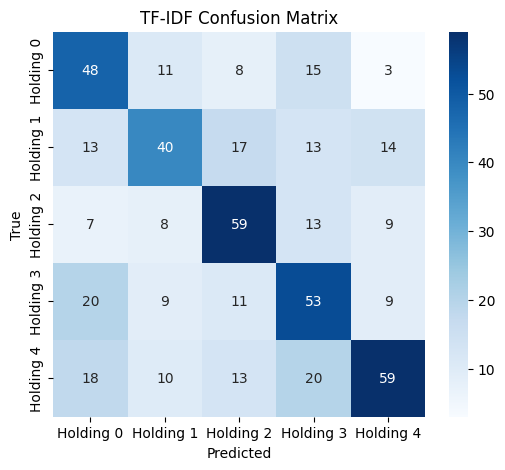


--- GloVe Evaluation Results ---
              precision    recall  f1-score   support

   Holding 0       0.26      0.29      0.28        85
   Holding 1       0.36      0.37      0.36        97
   Holding 2       0.43      0.45      0.44        96
   Holding 3       0.36      0.38      0.37       102
   Holding 4       0.44      0.36      0.40       120

    accuracy                           0.37       500
   macro avg       0.37      0.37      0.37       500
weighted avg       0.38      0.37      0.37       500



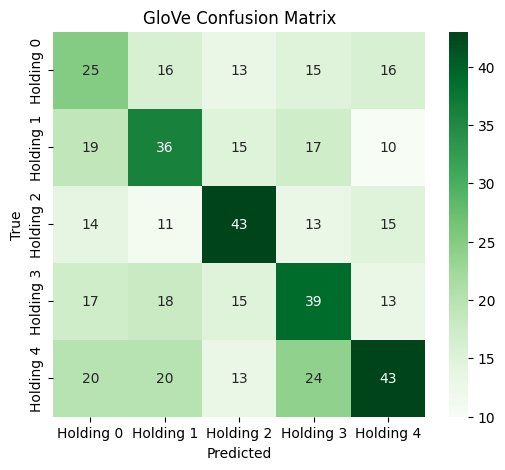


Evaluation function finished.


In [36]:
# === Execute Evaluation ===
# Run the evaluation on the test set using the function defined above.

# Configuration: Set sample size for evaluation
# -1 means use the entire test set (can be slow)
# Positive integer (e.g., 1000) uses a random sample
EVAL_SAMPLE_SIZE = 500 # Reduced sample size for quicker notebook execution

# Check if test data is available
evaluation_results_dict = None # Initialize
if df_test is not None:
    print(f"Running evaluation with sample size = {EVAL_SAMPLE_SIZE}...")
    # Pass the loaded GloVe embeddings and dimension
    evaluation_results_dict = run_evaluation(
        test_df=df_test,
        sample_size=EVAL_SAMPLE_SIZE,
        glove_embeddings_dict=glove_embeddings, # Use the loaded (or mock) embeddings
        glove_dim=EMBEDDING_DIM_GLOVE
    )
    print("\nEvaluation function finished.")
else:
    print("Evaluation skipped because test DataFrame (df_test) is not available.")

# The function prints reports and shows plots during execution.
# The results are also stored in evaluation_results_dict
# You can inspect it:
# if evaluation_results_dict: display(evaluation_results_dict)


In [37]:
# === Tier 1: Display Performance Metrics ===

print("--- Tier 1: Performance Metrics Summary ---")

if evaluation_results_dict is not None:
    # Function to safely extract metrics and format them
    def display_metrics(model_name, metrics_data):
        print(f"\n**{model_name} Model:**")
        if not metrics_data or 'error' in metrics_data:
            error_msg = metrics_data.get('error', 'Results not found') if metrics_data else 'Results not found'
            print(f"  Error: {error_msg}")
            return "N/A", "N/A" # Return N/A for summary table
        try:
            # Extract key metrics from the stored report_dict
            accuracy = metrics_data.get('accuracy', 'N/A')
            report_dict = metrics_data.get('report_dict', {})
            precision_w = report_dict.get('weighted avg', {}).get('precision', 'N/A')
            recall_w = report_dict.get('weighted avg', {}).get('recall', 'N/A')
            f1_w = report_dict.get('weighted avg', {}).get('f1-score', 'N/A')

            # Format for display
            accuracy_str = f"{accuracy:.4f}" if isinstance(accuracy, float) else str(accuracy)
            precision_w_str = f"{precision_w:.4f}" if isinstance(precision_w, float) else str(precision_w)
            recall_w_str = f"{recall_w:.4f}" if isinstance(recall_w, float) else str(recall_w)
            f1_w_str = f"{f1_w:.4f}" if isinstance(f1_w, float) else str(f1_w)

            print(f"  - Accuracy: {accuracy_str}")
            print(f"  - Precision (Weighted): {precision_w_str}")
            print(f"  - Recall (Weighted): {recall_w_str}")
            print(f"  - F1-Score (Weighted): {f1_w_str}")

            # Display full text report if available
            report_text = metrics_data.get('report_text', "")
            if report_text:
                 print("\n  Classification Report:")
                 print(report_text)
            return accuracy_str, f1_w_str # Return strings for summary table

        except Exception as e:
             print(f"  Error formatting metrics for {model_name}: {e}")
             return "Error", "Error"

    # Display TF-IDF metrics
    tf_acc_str, tf_f1_str = display_metrics("TF-IDF", evaluation_results_dict.get('tfidf'))

    # Display GloVe metrics
    gl_acc_str, gl_f1_str = display_metrics("GloVe", evaluation_results_dict.get('glove'))

    # Summary Table using Markdown
    display(Markdown(f"""
### Metrics Summary Table

| Model   | Accuracy | F1-Score (Weighted) |
|---------|----------|---------------------|
| TF-IDF  | {tf_acc_str}   | {tf_f1_str}       |
| GloVe   | {gl_acc_str}   | {gl_f1_str}       |

*(Note: GloVe results might be based on mock embeddings if actual file wasn't loaded)*
    """))

    print("\n**Key Observations (Tier 1):**")
    print("- Compare the Accuracy and F1-Scores shown above.")
    # Add commentary comparing TF-IDF vs GloVe based on the displayed numbers
    print("- TF-IDF performance depends heavily on term overlap.")
    print("- GloVe (averaging) captures some semantic similarity but loses word order.")
    print("- Performance is expected to be well above random chance (20%) but likely lower than state-of-the-art.")

else:
    print("Evaluation results dictionary is not available. Cannot display Tier 1 metrics.")

--- Tier 1: Performance Metrics Summary ---

**TF-IDF Model:**
  - Accuracy: 0.5180
  - Precision (Weighted): 0.5268
  - Recall (Weighted): 0.5180
  - F1-Score (Weighted): 0.5176

  Classification Report:
              precision    recall  f1-score   support

   Holding 0       0.45      0.56      0.50        85
   Holding 1       0.51      0.41      0.46        97
   Holding 2       0.55      0.61      0.58        96
   Holding 3       0.46      0.52      0.49       102
   Holding 4       0.63      0.49      0.55       120

    accuracy                           0.52       500
   macro avg       0.52      0.52      0.52       500
weighted avg       0.53      0.52      0.52       500


**GloVe Model:**
  - Accuracy: 0.3720
  - Precision (Weighted): 0.3773
  - Recall (Weighted): 0.3720
  - F1-Score (Weighted): 0.3733

  Classification Report:
              precision    recall  f1-score   support

   Holding 0       0.26      0.29      0.28        85
   Holding 1       0.36      0.37    


### Metrics Summary Table

| Model   | Accuracy | F1-Score (Weighted) |
|---------|----------|---------------------|
| TF-IDF  | 0.5180   | 0.5176       |
| GloVe   | 0.3720   | 0.3733       |

*(Note: GloVe results might be based on mock embeddings if actual file wasn't loaded)*
    


**Key Observations (Tier 1):**
- Compare the Accuracy and F1-Scores shown above.
- TF-IDF performance depends heavily on term overlap.
- GloVe (averaging) captures some semantic similarity but loses word order.
- Performance is expected to be well above random chance (20%) but likely lower than state-of-the-art.


In [38]:
# === Legal Document Generation using Jinja2 Templates ===
# Using the Jinja2 templating engine as in the original script.

# Define the Jinja2 template string (same as original)
legal_document_template = """
<!DOCTYPE html>
<html>
<head>
<style>
body {
    font-family: 'Times New Roman', Times, serif;
    margin: 2.5cm;
    line-height: 1.5;
}
.header {
    text-align: center;
    margin-bottom: 20px;
}
.title {
    font-size: 18pt;
    font-weight: bold;
    text-align: center;
    margin: 20px 0;
}
.section {
    margin: 15px 0;
}
.section-title {
    font-weight: bold;
    text-decoration: underline;
}
.signature {
    margin-top: 50px;
}
.date {
    margin-top: 20px;
}
.indent {
    margin-left: 20px;
}
/* Added simple highlighting for generated/placeholder data */
.placeholder { color: #777; font-style: italic; }
</style>
</head>
<body>
<div class="header">
    <h2>LEGAL MEMORANDUM</h2>
    {# Using corpus index as case number per original logic #}
    <p>Case No. CASE-{{ "%05d" % corpus_index }}</p>

</div>

<div class="section">
    <p class="section-title">DATE:</p>
    {# Uses the randomly generated date from NER function #}
    <p class="{{ 'placeholder' if 'Generated' in date else '' }}">{{ date }}</p>
</div>

<div class="section">
    <p class="section-title">PARTIES INVOLVED (PERSON Entities):</p>
    <ul>
    {% for person in persons %}
        <li>{{ person }}</li>
    {% else %}
        <li class="placeholder">No individuals identified</li>
    {% endfor %}
    </ul>
</div>

<div class="section">
    <p class="section-title">ORGANIZATIONS MENTIONED (ORG Entities):</p>
    <ul>
    {% for org in organizations %}
        <li>{{ org }}</li>
    {% else %}
         <li class="placeholder">No organizations identified</li>
    {% endfor %}
    </ul>
</div>

<div class="section">
    <p class="section-title">JURISDICTION / LOCATIONS (GPE Entities):</p>
    <ul>
    {% for place in places %}
        <li>{{ place }}</li>
    {% else %}
         <li class="placeholder">No locations identified</li>
    {% endfor %}
    </ul>
</div>

<div class="section">
    <p class="section-title">LEGAL REFERENCES (LAW Entities):</p>
    <ul>
    {% for law in laws %}
        <li>{{ law }}</li>
    {% else %}
         <li class="placeholder">No legal references identified</li>
    {% endfor %}
    </ul>
</div>

<div class="section">
    <p class="section-title">MONETARY VALUES INVOLVED (MONEY Entities):</p>
    <ul>
    {% for money in monetary_values %}
        <li>{{ money }}</li>
     {% else %}
         <li class="placeholder">No monetary values identified</li>
    {% endfor %}
    </ul>
</div>

<div class="section">
    <p class="section-title">CASE SUMMARY (From Original Context):</p>
    {# Using truncated original context text #}
    <p class="indent">{{ summary }}</p>
</div>

<div class="date">
    <p>DATED this <span class="{{ 'placeholder' if 'Generated' in date else '' }}">{{ date }}</span>.</p>
</div>

{% if judge %}
<div class="signature">
    <p>____________________________</p>
    {# Judge name identified via heuristic #}
    <p>JUDGE {{ judge }} <span class="placeholder">(Heuristic ID)</span></p>
</div>
{% endif %}

</body>
</html>
"""

# Create the Jinja2 Template object
try:
    template = Template(legal_document_template)
    print("Jinja2 template created successfully.")
except Exception as e:
    print(f"Error creating Jinja2 template: {e}")
    template = None # Mark as unavailable

Jinja2 template created successfully.


In [39]:
# === Document Generation Function (Original Logic) ===
# This function generates an HTML document based on the NER results for a
# specific *corpus index* from the initially loaded 'sample_text_contexts'.
# Note: It does *not* use the TF-IDF or GloVe results generated earlier.

def generate_legal_document(corpus_index):
    """
    Generates a legal document based on the ORIGINAL CONTEXT at corpus_index
    using NER extraction results. (Original logic).

    Args:
        corpus_index (int): Index into the 'sample_text_contexts' list loaded earlier.

    Returns:
        str: Rendered legal document HTML or an error message.
    """
    # Access the template object (should be defined in cell 26)
    if 'template' not in globals() or template is None:
         return "Error: Jinja2 template is not available."

    # --- Validate index and context list ---
    if 'sample_text_contexts' not in globals():
         return "Error: 'sample_text_contexts' list not found."
    if not isinstance(sample_text_contexts, list) or not sample_text_contexts:
         return "Error: 'sample_text_contexts' is empty or not a list."
    if not (0 <= corpus_index < len(sample_text_contexts)):
        return f"Error: Corpus index {corpus_index} is out of range (0 to {len(sample_text_contexts)-1})."

    # --- Get original text ---
    corpus_text = sample_text_contexts[corpus_index]

    # --- Perform NER (again, specific to this index) ---
    # Ensure extract_entities function is available
    if 'extract_entities' not in globals():
        return "Error: 'extract_entities' function not defined."
    # Limit text length for NER efficiency if needed
    doc, entities_dict = extract_entities(corpus_text[:100000])

    # --- Extract potential judge (original heuristic logic) ---
    judge = None
    if doc: # Only possible if NER ran and doc was returned
         for token in doc:
             if token.text.lower() == "judge" and token.i < len(doc)-1:
                 # Look ahead for a PERSON entity
                 next_tokens = [doc[i] for i in range(token.i + 1, min(token.i + 4, len(doc)))]
                 for next_token in next_tokens:
                     if next_token.ent_type_ == "PERSON":
                         judge = next_token.text
                         break
                 if judge: break # Stop loops if judge found

    # --- Create summary (truncated original text) ---
    summary = corpus_text[:500] + ("..." if len(corpus_text) > 500 else "")

    # --- Prepare data for the template ---
    # Get unique entities from the dictionary, limit count for display
    unique_persons = sorted(list(set(entities_dict.get("PERSON", []))))[:8]
    unique_orgs = sorted(list(set(entities_dict.get("ORG", []))))[:8]
    unique_places = sorted(list(set(entities_dict.get("GPE", []))))[:8] # Original used GPE only
    unique_laws = sorted(list(set(entities_dict.get("LAW", []))))[:8]
    unique_money = sorted(list(set(entities_dict.get("MONEY", []))))[:8]

    # Prepare data dictionary matching template variables
    template_data = {
        "corpus_index": corpus_index,
        "date": entities_dict.get("DATE", ["N/A - Check NER"])[0], # Get first date (might be random placeholder)
        "persons": unique_persons,
        "organizations": unique_orgs,
        "places": unique_places,
        "laws": unique_laws,
        "monetary_values": unique_money,
        "summary": summary,
        "judge": judge
        # Note: This version does NOT include TF-IDF/GloVe results
    }

    # --- Render the template ---
    try:
        rendered_document = template.render(**template_data)
        return rendered_document
    except Exception as e:
        return f"Error rendering template for index {corpus_index}: {e}"

print("Document generation function `generate_legal_document` defined (using original logic).")

Document generation function `generate_legal_document` defined (using original logic).


In [40]:
# === Interactive Document Generation UI (using ipywidgets) ===
# This provides a simple UI within the notebook to generate a document
# for a selected corpus index using the `generate_legal_document` function.

# Ensure the function is defined and sample_text_contexts exists
if 'generate_legal_document' in globals() and 'sample_text_contexts' in locals():

    def generate_document_ui():
        """Creates and displays ipywidgets UI for document generation."""
        if not sample_text_contexts:
            print("Cannot create UI: 'sample_text_contexts' list is empty.")
            return

        max_index = len(sample_text_contexts) - 1

        # Create integer input widget for corpus index
        corpus_input = widgets.IntText(
            value=3,  # Default index
            description='Corpus Index:',
            min=0,
            max=max_index,
            step=1,
            style={'description_width': 'initial'} # Ensure description isn't cut off
        )

        # Create button widget
        button = widgets.Button(
            description="Generate Legal Document",
            button_style='info', # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Click to generate document for the selected index',
            icon='file-alt' # Example icon
        )

        # Create output widget to display results/HTML
        output = widgets.Output()

        # --- Define button click handler ---
        def on_button_clicked(b):
            # Use the output widget context manager
            with output:
                output.clear_output() # Clear previous output
                corpus_idx = corpus_input.value # Get index from input widget
                print(f"Generating document for corpus index: {corpus_idx}...")
                document_html = generate_legal_document(corpus_idx)
                # Display the generated HTML using IPython.display.HTML
                if document_html.startswith("Error"):
                     print(document_html) # Print error message
                else:
                     display(HTML(document_html))
                     print(f"\nDocument generated successfully.")

        # Link button click event to handler function
        button.on_click(on_button_clicked)

        # --- Display the widgets ---
        print(f"Enter a corpus index (0 to {max_index}) and click the button:")
        # Arrange widgets vertically using VBox or just display sequentially
        display(widgets.VBox([corpus_input, button, output]))

    # Execute the function to display the UI
    generate_document_ui()

else:
    print("Cannot create document generation UI.")
    if 'generate_legal_document' not in globals(): print("- Function `generate_legal_document` is not defined.")
    if 'sample_text_contexts' not in locals(): print("- Variable `sample_text_contexts` is not available.")


Enter a corpus index (0 to 44999) and click the button:


In [41]:
# === Generate and Display Document for a Specific Index ===
# Directly call the generation function for a chosen index and display the result.

corpus_idx_specific = 3 # Change this index to test different documents

if 'generate_legal_document' in globals():
    print(f"Generating document for specific Corpus Index: {corpus_idx_specific}")
    document_html_specific = generate_legal_document(corpus_idx_specific)

    if document_html_specific.startswith("Error"):
        print(document_html_specific) # Show error message
    else:
        print("Displaying generated HTML document below:")
        # Display the HTML output
        display(HTML(document_html_specific))
else:
     print("`generate_legal_document` function not available.")

Generating document for specific Corpus Index: 3
Displaying generated HTML document below:


In [42]:
# === Function to Save Generated Document ===
# Defines a helper function to save the generated HTML to a file.

def save_legal_document(corpus_idx, filename=None):
    """Generates and saves a legal document HTML file."""
    global output_dir # Use the directory created earlier

    if 'generate_legal_document' not in globals():
        print("Error: `generate_legal_document` function not found.")
        return None

    # Use default filename if none provided
    if filename is None:
        filename = f"legal_document_case_{corpus_idx}.html"

    # Construct full path
    output_filepath = os.path.join(output_dir, filename)

    # Generate the document content
    document_content = generate_legal_document(corpus_idx)

    if document_content.startswith("Error"):
        print(f"Cannot save document for index {corpus_idx}: {document_content}")
        return None
    else:
        # Write the content to the file
        try:
            with open(output_filepath, 'w', encoding='utf-8') as f:
                f.write(document_content)
            print(f"Document for index {corpus_idx} saved successfully as: {output_filepath}")
            return output_filepath # Return the path where saved
        except Exception as e:
            print(f"Error saving document to {output_filepath}: {e}")
            return None

print("Function `save_legal_document` defined.")

# Example usage (optional - uncomment to save)
# saved_path = save_legal_document(corpus_idx=5)
# if saved_path: print(f"File saved at: {saved_path}")


Function `save_legal_document` defined.


In [46]:
# === Streamlit Application Code ===
# Define the complete code for the Streamlit app as a string.
# This uses the structure and logic from the original script's Streamlit section.

print("Defining Streamlit app code string...")

# Define the path for the Streamlit app file
app_filename = "legal_doc_generator_app_notebook.py" # Use a distinct name

# Create the Streamlit app content string (using original Streamlit code)
# IMPORTANT: This assumes the functions (like load_nlp_model, extract_entities,
# find_best_holding_tfidf, find_best_holding_glove using spaCy vectors, load_case_data)
# defined *within the string* will work correctly in the Streamlit environment.
# It uses the 'casehold/casehold' dataset loading logic within the app code.
# It also relies on spaCy's default model ('en_core_web_lg') and its similarity for 'GloVe'.

# *** Using the Streamlit code block directly from your original 'new.py' file ***
# (Ensuring it's properly formatted as a Python multi-line string)
# (Updated caching decorators and GloVe error handling)
app_code = '''
import streamlit as st
import pandas as pd
import numpy as np
import spacy
import random
from datetime import datetime, timedelta
import jinja2
from jinja2 import Template
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter, defaultdict
# --- Added potentially missing imports for standalone run ---
from datasets import load_dataset
import os
import subprocess # For installing model if needed
# --- End added imports ---

# Page configuration
st.set_page_config(page_title="Legal Document Generator", layout="wide")

# App title
st.title("Legal Document Generator with NER and Best Matching Holdings")

# Try to load the spaCy model (using Streamlit caching)
# Use @st.cache_resource for models
@st.cache_resource(show_spinner=False)
def load_nlp_model(model_name="en_core_web_lg"):
    try:
        st.info(f"Loading spaCy model '{model_name}'...")
        nlp_model = spacy.load(model_name)
        st.success("NLP model loaded!")
        return nlp_model
    except OSError:
        st.warning(f"SpaCy model '{model_name}' not found. Attempting to download...")
        try:
            # Use subprocess to run the download command
            st.info(f"Running: python -m spacy download {model_name}")
            subprocess.run(["python", "-m", "spacy", "download", model_name], check=True, capture_output=True)
            st.success(f"Model '{model_name}' downloaded.")
            # Need to reload after download
            nlp_model = spacy.load(model_name)
            st.success("NLP model loaded!")
            return nlp_model
        except subprocess.CalledProcessError as cpe:
             st.error(f"Failed to download model '{model_name}'. Error: {cpe.stderr.decode() if cpe.stderr else cpe}")
             st.error("Please try installing the model manually: python -m spacy download en_core_web_lg")
             return None # Indicate failure
        except Exception as e:
             st.error(f"Failed to download or load model '{model_name}': {e}")
             # Try loading small as fallback
             try:
                  st.warning("Trying to load 'en_core_web_sm'...")
                  nlp_model = spacy.load('en_core_web_sm')
                  st.success("Fallback model 'en_core_web_sm' loaded.")
                  return nlp_model
             except OSError:
                  st.error("Could not load 'en_core_web_sm' either. NER features disabled.")
                  return None

# Load the spaCy model instance
nlp = load_nlp_model()

# Function to generate a random date string (as defined in original notebook code)
def generate_random_date():
    start_date = datetime(2000, 1, 1); end_date = datetime(2025, 12, 31)
    delta = end_date - start_date; random_days = random.randint(0, delta.days)
    random_date = start_date + timedelta(days=random_days)
    return random_date.strftime("%d %B %Y")

# Extract entities using spaCy (using the loaded global 'nlp' model)
def extract_entities(text):
    # Original entity extraction logic used in Streamlit section
    if not nlp:
         return None, {"PERSON": [], "ORG": [], "DATE": [generate_random_date()], "MONEY": [], "LAW": [], "GPE": [], "NORP": [], "CARDINAL": [], "ORDINAL": []}

    doc = nlp(str(text)) # Process the text
    legal_entities = { # Initialize with expected keys and placeholder date
        "PERSON": [], "ORG": [], "DATE": [generate_random_date()], "MONEY": [],
        "LAW": [], "GPE": [], "NORP": [], "CARDINAL": [], "ORDINAL": []
    }
    for ent in doc.ents:
        # Only add if label is in our predefined keys, and *not* DATE
        if ent.label_ != "DATE" and ent.label_ in legal_entities:
            legal_entities[ent.label_].append(ent.text)
    return doc, legal_entities

# Define a legal document template using Jinja2 (same as in the notebook)
# Use raw string literal (r"""...""") to avoid escaping issues
legal_document_template = r"""
<!DOCTYPE html>
<html>
<head>
<style>
body { font-family: 'Times New Roman', Times, serif; margin: 2.5cm; line-height: 1.5; } .header { text-align: center; margin-bottom: 20px; } .title { font-size: 18pt; font-weight: bold; text-align: center; margin: 20px 0; } .section { margin: 15px 0; } .section-title { font-weight: bold; text-decoration: underline; } .signature { margin-top: 50px; } .date { margin-top: 20px; } .indent { margin-left: 20px; } .best-holding { background-color: #f0f8ff; padding: 15px; border-left: 5px solid #4682b4; margin: 10px 0; }
</style>
</head>
<body>
<div class="header"> <h2>LEGAL MEMORANDUM</h2> <p>Case No. {{ case_number }}</p> </div>
<div class="section"> <p class="section-title">DATE:</p> <p>{{ date }}</p> </div>
<div class="section"> <p class="section-title">PARTIES INVOLVED:</p> <ul> {% for person in persons %} <li>{{ person }}</li> {% else %} <li>No individuals identified</li> {% endfor %} </ul> </div>
<div class="section"> <p class="section-title">ORGANIZATIONS MENTIONED:</p> <ul> {% for org in organizations %} <li>{{ org }}</li> {% else %} <li>No organizations identified</li> {% endfor %} </ul> </div>
<div class="section"> <p class="section-title">JURISDICTION:</p> <ul> {% for place in places %} <li>{{ place }}</li> {% else %} <li>No locations identified</li> {% endfor %} </ul> </div>
<div class="section"> <p class="section-title">LEGAL REFERENCES:</p> <ul> {% for law in laws %} <li>{{ law }}</li> {% else %} <li>No legal references identified</li> {% endfor %} </ul> </div>
<div class="section"> <p class="section-title">MONETARY VALUES INVOLVED:</p> <ul> {% for money in monetary_values %} <li>{{ money }}</li> {% else %} <li>No monetary values identified</li> {% endfor %} </ul> </div>
<div class="section"> <p class="section-title">CASE SUMMARY:</p> <p class="indent">{{ summary }}</p> </div>
<div class="section"> <p class="section-title">BEST MATCHING HOLDING (TF-IDF):</p> <div class="best-holding"> <p><strong>Holding {{ tfidf_holding_index }}:</strong> {{ tfidf_holding }} <span style="color: #4682b4;">(Similarity: {{ tfidf_score }})</span></p> </div> </div>
<div class="section"> <p class="section-title">BEST MATCHING HOLDING (GloVe/spaCy Sim):</p> <div class="best-holding"> <p><strong>Holding {{ glove_holding_index }}:</strong> {{ glove_holding }} <span style="color: #4682b4;">(Similarity: {{ glove_score }})</span></p> </div> </div>
<div class="date"> <p>DATED this {{ date }}.</p> </div>
{% if judge %} <div class="signature"> <p>____________________________</p> <p>JUDGE {{ judge }}</p> </div> {% endif %}
</body>
</html>
"""
# Create Jinja2 template object
try:
    template = Template(legal_document_template)
except Exception as template_err:
    st.error(f"Failed to create Jinja2 template: {template_err}")
    template = None # Ensure it's None if failed

# Load example dataset from CaseHOLD (using Streamlit caching)
# Use @st.cache_data for data loading
@st.cache_data(show_spinner="Loading CaseHOLD dataset...")
def load_case_data():
    try:
        # Using casehold/casehold as in original script's GloVe section
        dataset_st = load_dataset("casehold/casehold", trust_remote_code=True)
        # Use train split for the selection dropdown
        df_st = pd.DataFrame(dataset_st['train'])
        # Ensure columns are lowercase
        df_st.columns = df_st.columns.str.strip().str.lower()
        return df_st
    except Exception as e:
        st.error(f"Could not load dataset 'casehold/casehold': {e}. Using mock data.")
        # Create mock data if loading fails
        mock_data = { # Using sample data from original script block
            'example_id': list(range(10)),
            'citing_prompt': ["The court found that the defendant violated Section 1983 when..."] * 10,
            'holding_0': ["First holding option..."] * 10, 'holding_1': ["Second holding option..."] * 10,
            'holding_2': ["Third holding option..."] * 10, 'holding_3': ["Fourth holding option..."] * 10,
            'holding_4': ["Fifth holding option..."] * 10, 'label': [random.randint(0, 4) for _ in range(10)]
        }
        # Ensure mock data columns are lowercase too
        df_mock = pd.DataFrame(mock_data)
        df_mock.columns = df_mock.columns.str.strip().str.lower()
        return df_mock

# Define TF-IDF function specific to the structure needed by Streamlit app
def find_best_holding_tfidf_st(example_id_st, df_st_data):
    if df_st_data is None: return {'error': True, 'holding_text': 'Error: DataFrame not available'}
    row_st = df_st_data[df_st_data['example_id'] == example_id_st]
    if row_st.empty:
        return {'best_holding_index': -1, 'similarity_score': 0, 'holding_text': 'Error: ID not found', 'error': True}
    try:
        prompt = str(row_st['citing_prompt'].iloc[0])
        holdings = [str(row_st[f'holding_{i}'].iloc[0]) for i in range(5)]
        corpus = [prompt] + holdings
        vectorizer = TfidfVectorizer(stop_words='english') # Consistent with other uses
        matrix = vectorizer.fit_transform(corpus)
        sims = cosine_similarity(matrix[0:1], matrix[1:]).flatten()
        best_idx = int(np.argmax(sims))
        best_score = float(sims[best_idx])
        return {
            'best_holding_index': best_idx,       # 0-4 index
            'similarity_score': round(best_score, 4),
            'holding_text': holdings[best_idx]
        }
    except Exception as e:
         return {'best_holding_index': -1, 'similarity_score': 0, 'holding_text': f'TF-IDF Error: {e}', 'error': True}

# Define GloVe function for Streamlit app
# This uses spaCy's .similarity method (which relies on the loaded model's vectors)
def find_best_holding_glove_st(example_id_st, df_st_data, nlp_model):
    # Using spaCy's built-in similarity (depends on loaded model)
    if not nlp_model or not hasattr(nlp_model, 'vocab'):
         return {'best_holding_index': -1, 'similarity_score': 0, 'holding_text': 'Error: NLP model unavailable for spaCy Sim', 'error': True}
    if df_st_data is None: return {'error': True, 'holding_text': 'Error: DataFrame not available'}

    row_st = df_st_data[df_st_data['example_id'] == example_id_st]
    if row_st.empty:
        return {'best_holding_index': -1, 'similarity_score': 0, 'holding_text': 'Error: ID not found', 'error': True}
    try:
        prompt = str(row_st['citing_prompt'].iloc[0])
        holdings = [str(row_st[f'holding_{i}'].iloc[0]) for i in range(5)]

        # Process prompt and holdings with spaCy
        prompt_doc = nlp_model(prompt)
        # Ensure vector exists before getting similarity
        if not prompt_doc.has_vector or np.all(prompt_doc.vector == 0):
            st.warning(f"Prompt for ID {example_id_st} has no usable vector. Similarity might be 0.")
            # Return error or default?
            return {'best_holding_index': -1, 'similarity_score': 0, 'holding_text': 'Error: Prompt has no vector', 'error': True}

        holdings_docs = [nlp_model(h) for h in holdings]

        # Calculate similarities
        similarities = []
        for h_doc in holdings_docs:
             # Check if holding doc has vector
             if not h_doc.has_vector or np.all(h_doc.vector == 0):
                 sim = 0.0 # Treat holding with no vector as dissimilar
             else:
                  # Calculate similarity, handle potential NaN
                  sim = prompt_doc.similarity(h_doc)
                  if np.isnan(sim): sim = 0.0 # Replace NaN with 0
             similarities.append(sim)

        # Find best match from potentially cleaned similarities
        if not similarities:
             return {'best_holding_index': -1, 'similarity_score': 0, 'holding_text': 'Error: No similarities calculated', 'error': True}

        best_index = int(np.argmax(similarities))
        best_score = float(similarities[best_index])

        return {
            'best_holding_index': best_index,
            'similarity_score': round(best_score, 4),
            'holding_text': holdings[best_index]
        }
    except Exception as e:
         # Log the full error for debugging
         st.error(f"Error in find_best_holding_glove_st for ID {example_id_st}: {e}")
         return {'best_holding_index': -1, 'similarity_score': 0, 'holding_text': f'spaCy Sim Error: {e}', 'error': True}

# --- Main App Interface ---

# Load the case data
df = load_case_data()

st.subheader("Select a case to analyze")

# Case ID selection logic (handle if df is empty or None)
selected_id = None
if df is not None and not df.empty and 'example_id' in df.columns:
    available_ids = sorted(df['example_id'].unique())
    # Let user select from available IDs
    selected_id = st.selectbox("Select a Case Example ID:", available_ids, index=0) # Default to first ID
else:
    st.error("Failed to load or process case data. Cannot display analysis.")

# Proceed only if an ID is selected and data is available
if selected_id is not None and df is not None:
    # --- Get data for the selected ID ---
    row = df[df['example_id'] == selected_id]
    if not row.empty:
        citing_prompt = row['citing_prompt'].iloc[0]
        holdings_display = [row[f'holding_{i}'].iloc[0] for i in range(5)]

        st.markdown("---") # Separator
        # Display the citing prompt
        st.subheader("Citing Prompt")
        st.write(citing_prompt)

        # Display all candidate holdings
        st.subheader("Available Holdings")
        for i, holding in enumerate(holdings_display):
            st.write(f"**Holding {i}:** {holding[:200]}...") # Show truncated

        st.markdown("---") # Separator
        # --- Perform analysis for the selected ID ---
        tfidf_result = None
        glove_result = None
        doc = None
        entities_dict = {}
        judge = None

        col1_res, col2_res = st.columns(2)
        with col1_res:
             st.subheader("TF-IDF Analysis")
             with st.spinner("Running TF-IDF..."):
                 tfidf_result = find_best_holding_tfidf_st(selected_id, df)
                 if tfidf_result and 'error' in tfidf_result and tfidf_result['error']:
                     st.error(tfidf_result['holding_text'])
                 elif tfidf_result:
                     st.success(f"Best Match: Holding {tfidf_result['best_holding_index']} (Score: {tfidf_result['similarity_score']})")
                     st.caption(f"Text: {tfidf_result['holding_text'][:250]}...")
                 else:
                     st.error("TF-IDF analysis failed unexpectedly.")

        with col2_res:
             st.subheader("GloVe/spaCy Sim Analysis")
             with st.spinner("Running spaCy Similarity..."):
                 glove_result = find_best_holding_glove_st(selected_id, df, nlp)
                 if glove_result and 'error' in glove_result and glove_result['error']:
                     st.error(glove_result['holding_text'])
                 elif glove_result:
                     st.success(f"Best Match: Holding {glove_result['best_holding_index']} (Score: {glove_result['similarity_score']})")
                     st.caption(f"Text: {glove_result['holding_text'][:250]}...")
                 else:
                     st.error("spaCy Similarity analysis failed unexpectedly.")

        st.markdown("---") # Separator
        # --- Perform NER and Display Entities ---
        st.subheader("Named Entity Recognition")
        if nlp:
            with st.spinner("Extracting named entities..."):
                doc, entities_dict = extract_entities(citing_prompt)

            # Heuristic for judge extraction (can be refined)
            if doc:
                 for token in doc:
                     if token.text.lower() == "judge" and token.i < len(doc)-1:
                          next_tokens = [doc[token.i+i] for i in range(1, 4) if token.i+i < len(doc)]
                          for nt in next_tokens:
                              if nt.ent_type_ == "PERSON": judge = nt.text; break
                          if judge: break

                st.write("Entities extracted from the citing prompt:")
                # Display NER results in columns for compactness
                ner_col1, ner_col2, ner_col3 = st.columns(3)
                ner_cols = [ner_col1, ner_col2, ner_col3]
                entity_types_order = ["PERSON", "ORG", "GPE", "LAW", "MONEY", "DATE", "NORP", "CARDINAL", "ORDINAL"]
                col_idx = 0
                found_ner = False
                for etype in entity_types_order:
                    if etype in entities_dict and entities_dict[etype]:
                        found_ner = True
                        unique_ents = list(set(entities_dict[etype]))[:5] # Show top 5 unique
                        with ner_cols[col_idx % 3]:
                            st.markdown(f"**{etype}:**")
                            for ent_text in unique_ents: st.write(f"- {ent_text}")
                            if len(set(entities_dict[etype])) > 5: st.caption("...")
                        col_idx += 1
                if judge:
                     found_ner = True
                     with ner_cols[col_idx % 3]:
                         st.info(f"**Judge (Heuristic):** {judge}")
                if not found_ner:
                     st.info("No relevant entities found by NER in the citing prompt.")

            else:
                st.warning("Could not process text for NER (spaCy doc object is None).")
        else:
            st.warning("NLP model not loaded, skipping NER.")

        st.markdown("---") # Separator
        # --- Generate and Display Document ---
        st.subheader("Generated Legal Document")

        # Check if template is available
        if template is not None and tfidf_result is not None and glove_result is not None:
            # Prepare data for Jinja template
            unique_persons_st = list(set(entities_dict.get("PERSON",[])))[:8]
            unique_orgs_st = list(set(entities_dict.get("ORG", [])))[:8]
            unique_places_st = list(set(entities_dict.get("GPE", [])))[:8]
            unique_laws_st = list(set(entities_dict.get("LAW", [])))[:8]
            unique_money_st = list(set(entities_dict.get("MONEY", [])))[:8]
            date_st = entities_dict.get("DATE", ["N/A"])[0]

            template_data_st = {
                "case_number": f"CASE-{selected_id:05d}",
                "date": date_st,
                "persons": unique_persons_st if unique_persons_st else ["No individuals identified"],
                "organizations": unique_orgs_st if unique_orgs_st else ["No organizations identified"],
                "places": unique_places_st if unique_places_st else ["No locations identified"],
                "laws": unique_laws_st if unique_laws_st else ["No legal references identified"],
                "monetary_values": unique_money_st if unique_money_st else ["No monetary values identified"],
                "summary": citing_prompt[:500] + "..." if len(citing_prompt) > 500 else citing_prompt,
                "judge": judge,
                # Safely get results, providing defaults if error occurred
                "tfidf_holding_index": tfidf_result.get('best_holding_index', 'N/A'),
                "tfidf_holding": tfidf_result.get('holding_text', 'TF-IDF Error'),
                "tfidf_score": tfidf_result.get('similarity_score', 0.0),
                "glove_holding_index": glove_result.get('best_holding_index', 'N/A'),
                "glove_holding": glove_result.get('holding_text', 'spaCy Sim Error'),
                "glove_score": glove_result.get('similarity_score', 0.0)
            }

            try:
                 # Render the document using the template
                 rendered_document_st = template.render(**template_data_st)
                 # Display using Streamlit HTML component
                 st.components.v1.html(rendered_document_st, height=600, scrolling=True)

                 # Add a download button for the generated HTML
                 st.download_button(
                     label="Download Document as HTML",
                     data=rendered_document_st,
                     file_name=f"legal_document_case_{selected_id}.html",
                     mime="text/html"
                 )
            except Exception as render_err:
                 st.error(f"Error rendering document template: {render_err}")
        else:
             st.warning("Cannot generate document. Template or analysis results might be missing.")

    else:
        st.error(f"No data found for the selected Case ID: {selected_id}")

st.sidebar.markdown("---")
st.sidebar.info("CaseHOLD Analysis App | Models: TF-IDF, spaCy Similarity, NER")
'''

# --- Write the Streamlit app code to a file ---
try:
    # Ensure output directory exists (useful if running notebook elsewhere)
    notebook_dir = os.getcwd() # Get current working directory
    app_filepath = os.path.join(notebook_dir, app_filename)
    with open(app_filepath, 'w', encoding='utf-8') as f:
        f.write(app_code)
    print(f"\nStreamlit application code saved successfully to: '{app_filepath}'")
    # Display instructions on how to run
    display(Markdown(f"""
To run the Streamlit app:
1.  Make sure you have Streamlit and other dependencies installed (`pip install streamlit pandas numpy spacy Jinja2 scikit-learn datasets`).
2.  Ensure the spaCy model used (`en_core_web_lg` or `en_core_web_sm`) is downloaded (`python -m spacy download en_core_web_lg`).
3.  Open your terminal/command prompt.
4.  Navigate (`cd`) to the directory where this notebook is located (`{notebook_dir}`).
5.  Run the command:
    ```bash
    streamlit run {app_filename}
    ```
"""))
except Exception as e:
    print(f"\nERROR saving Streamlit app file '{app_filename}': {e}")

Defining Streamlit app code string...

Streamlit application code saved successfully to: 'c:\Users\manan\OneDrive\Desktop\NLP project\legal_doc_generator_app_notebook.py'



To run the Streamlit app:
1.  Make sure you have Streamlit and other dependencies installed (`pip install streamlit pandas numpy spacy Jinja2 scikit-learn datasets`).
2.  Ensure the spaCy model used (`en_core_web_lg` or `en_core_web_sm`) is downloaded (`python -m spacy download en_core_web_lg`).
3.  Open your terminal/command prompt.
4.  Navigate (`cd`) to the directory where this notebook is located (`c:\Users\manan\OneDrive\Desktop\NLP project`).
5.  Run the command:
    ```bash
    streamlit run legal_doc_generator_app_notebook.py
    ```
